# Multi drone
12200569 김찬영

# Initial Settings

In [11]:
import sys
print(sys.executable)

c:\Users\142857\AppData\Local\Programs\Python\Python312\python.exe


In [12]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
import random

N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

# x_0 = np.array([10, -20, 15, -5])
# x_des = np.array([100, 50, 0, 0])

In [13]:
def plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N):
    """
    드론 궤적 시각화 함수

    Parameters:
    - x_cps: 상태 trajectory 리스트 (각 드론마다 4xN 배열)
    - u_cps: 입력 trajectory 리스트 (각 드론마다 2xN 배열)
    - x_0s: 초기 위치 리스트 (각 드론마다 2차원 벡터)
    - x_dess: 목표 위치 리스트 (각 드론마다 2차원 벡터)
    - N: 시뮬레이션 길이
    """

    plt.figure(figsize=(14,9), dpi=100)

    num_drones = len(x_cps)
    line_styles = ['-', '--', '-.', ':']  # 다양한 선 스타일

    for i in range(num_drones):
        style = line_styles[i % len(line_styles)]
        plt.plot(x_cps[i][0,:], x_cps[i][1,:], style, label=f'drone {i+1}')
        plt.plot(x_0s[i][0], x_0s[i][1], 'o', markersize=7, label=f'Initial position ({i+1})')
        plt.plot(x_dess[i][0], x_dess[i][1], '*', markersize=10, label=f'Target position ({i+1})')

    # 속도 벡터 화살표
    for i in range(0, N-1, 10):
        for j in range(num_drones):
            plt.arrow(
                x_cps[j][0, i], x_cps[j][1, i],
                10 * u_cps[j][0, i], 10 * u_cps[j][1, i],
                head_width=0.2, width=0.2, fc='tab:red', ec='none'
            )

    plt.title('Drone Trajectories')
    plt.legend()
    plt.axis('equal')
    plt.xlabel(r'$x$ position')
    plt.ylabel(r'$y$ position')
    plt.grid()
    plt.show()

import matplotlib.pyplot as plt

def plot_drone_states_controls(x_opts, u_opts, ts):
    """
    드론들의 상태(x) 및 제어입력(u) 궤적을 시각화하는 함수

    Parameters:
    - x_opts: 상태 trajectory 리스트 (각 드론마다 4xN 배열)
    - u_opts: 제어입력 trajectory 리스트 (각 드론마다 2x(N-1) 배열)
    - ts: 시간 벡터 (길이 N)
    """

    num_drones = len(x_opts)
    N = x_opts[0].shape[1]

    # 상태 시각화
    plt.figure(figsize=(14, 9), dpi=100)
    state_labels = ['x position', 'y position', 'x velocity', 'y velocity']
    for state_idx in range(4):
        plt.subplot(2, 2, state_idx + 1)
        for drone_idx in range(num_drones):
            plt.plot(ts, x_opts[drone_idx][state_idx, :], label=f'drone {drone_idx+1}')
        plt.xlabel('time')
        plt.ylabel(state_labels[state_idx])
        plt.grid()
        if state_idx == 0:
            plt.legend()
    plt.suptitle('Drone States')
    plt.tight_layout()
    plt.show()

    # 제어입력 시각화
    plt.figure(figsize=(14, 6), dpi=100)
    control_labels = [r'$u_1$', r'$u_2$']
    for control_idx in range(2):
        plt.subplot(1, 2, control_idx + 1)
        for drone_idx in range(num_drones):
            plt.plot(ts[:-1], u_opts[drone_idx][control_idx, :], label=f'drone {drone_idx+1}')
        plt.xlabel('time')
        plt.ylabel(control_labels[control_idx])
        plt.grid()
        if control_idx == 0:
            plt.legend()
    plt.suptitle('Drone Control Inputs')
    plt.tight_layout()
    plt.show()


def sin(x):
  return np.sin(x)

def cos(x):
  return np.cos(x)

pi = np.pi

def indicator(var, set):
    if var in set:
        return 0
    else:
        return 10000000000
    
def plot_scp_iteration(iter_id, x1_cp_hist, x2_cp_hist, u1_cp_hist, u2_cp_hist,
                       x1_0, x2_0, x1_des, x2_des, ts, N, objval_hist=None):
    """
    특정 iteration에 대한 SCP 결과를 플로팅합니다.

    Parameters:
    - iter_id: 확인할 iteration 번호
    - x1_cp_hist, x2_cp_hist: 각 드론의 상태 변수 히스토리 (list of ndarray)
    - u1_cp_hist, u2_cp_hist: 각 드론의 제어 입력 히스토리 (list of ndarray)
    - x1_0, x2_0: 초기 위치 (np.array)
    - x1_des, x2_des: 목표 위치 (np.array)
    - ts: 시간 벡터
    - N: 시뮬레이션 길이 (time step 개수)
    - objval_hist: objective 값 히스토리 (list or ndarray, optional)
    """

    assert 0 <= iter_id < len(x1_cp_hist), "iter_id out of range."

    # 상태 변수 plot
    plt.figure(figsize=(14,6), dpi=100)
    labels = [r'$p_x$', r'$p_y$', r'$v_x$', r'$v_y$']
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.plot(ts, x1_cp_hist[iter_id][i,:], label='x1', linewidth=2)
        plt.plot(ts, x2_cp_hist[iter_id][i,:], label='x2', linewidth=2)
        plt.xlabel('time'); plt.ylabel(labels[i]); plt.grid(); plt.legend()
    plt.suptitle(f'Drone States at Iteration {iter_id}')
    plt.show()

    # 제어 입력 plot
    plt.figure(figsize=(14,6), dpi=100)
    plt.subplot(2,2,1)
    plt.plot(ts[:-1], u1_cp_hist[iter_id][0,:], label='u1', linewidth=2)
    plt.plot(ts[:-1], u2_cp_hist[iter_id][0,:], label='u2', linewidth=2)
    plt.xlabel('time'); plt.ylabel(r'$u_x$'); plt.grid(); plt.legend()

    plt.subplot(2,2,2)
    plt.plot(ts[:-1], u1_cp_hist[iter_id][1,:], label='u1', linewidth=2)
    plt.plot(ts[:-1], u2_cp_hist[iter_id][1,:], label='u2', linewidth=2)
    plt.xlabel('time'); plt.ylabel(r'$u_y$'); plt.grid(); plt.legend()
    plt.suptitle(f'Drone Controls at Iteration {iter_id}')
    plt.show()

    # 노름 plot
    plt.figure(figsize=(14,4), dpi=100)
    plt.plot(ts[:-1], np.linalg.norm(u1_cp_hist[iter_id], axis=0), label='||u1||', linewidth=2)
    plt.plot(ts[:-1], np.linalg.norm(u2_cp_hist[iter_id], axis=0), label='||u2||', linewidth=2)
    plt.xlabel('time'); plt.ylabel(r'$||u||$'); plt.grid(); plt.legend()
    plt.title(f'Control Norms at Iteration {iter_id}')
    plt.show()

    # 궤적 plot
    plt.figure(figsize=(10,8))
    plt.plot(x1_0[0], x1_0[1], 'o', label='x1 init')
    plt.plot(x2_0[0], x2_0[1], 'o', label='x2 init')
    plt.plot(x1_des[0], x1_des[1], '*', label='x1 target')
    plt.plot(x2_des[0], x2_des[1], '*', label='x2 target')
    plt.plot(x1_cp_hist[iter_id][0,:], x1_cp_hist[iter_id][1,:], label='x1 traj', linewidth=2)
    plt.plot(x2_cp_hist[iter_id][0,:], x2_cp_hist[iter_id][1,:], label='x2 traj', linewidth=2)

    for t in range(0, N, 10):
        plt.arrow(x1_cp_hist[iter_id][0,t], x1_cp_hist[iter_id][1,t],
                  10*u1_cp_hist[iter_id][0,t], 10*u1_cp_hist[iter_id][1,t],
                  head_width=1.2, width=0.1, color='r')
        plt.arrow(x2_cp_hist[iter_id][0,t], x2_cp_hist[iter_id][1,t],
                  10*u2_cp_hist[iter_id][0,t], 10*u2_cp_hist[iter_id][1,t],
                  head_width=1.2, width=0.1, color='r')

    plt.xlabel(r'$x$ position'); plt.ylabel(r'$y$ position')
    plt.title(f'Trajectories at Iteration {iter_id}')
    if objval_hist is not None:
        title = f'iter = {iter_id}| Objective = {objval_hist[iter_id]:.2f}'
    else:
        title = f'iter = {iter_id}'
    plt.title(title)
    plt.axis('equal'); plt.grid(); plt.legend()
    plt.show()


# Convex Program

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 12 07:08:34 PM: Your problem has 12008 variables, 8016 constraints, and 0 parameters.
(CVXPY) May 12 07:08:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 07:08:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 07:08:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 12 07:08:35 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 07:08:35 PM: Compiling problem (target solver=OSQP)

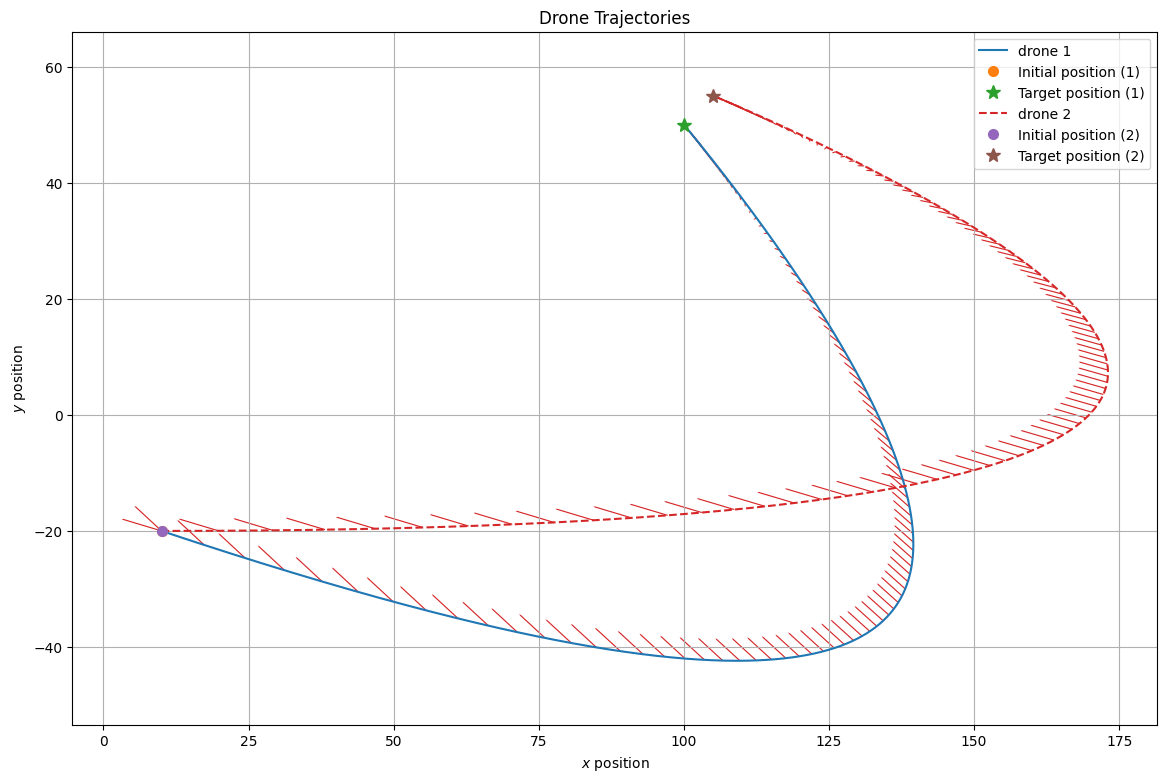

In [5]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}

x2 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u2 = cp.Variable((2,N))    # u_{0},...,u_{N-1}

u_lb = np.array([-1, -1])*0.7
u_ub = np.array([ 1,  1])*0.7

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x1_0 = np.array([10, -20, 15, -5])
x1_des = np.array([100, 50, 0, 0])

x2_0 = x1_0 + np.array([0, 0, 5, 5])
x2_des = x1_des + np.array([5, 5, 0, 0])

obj = cp.sum_squares(u1) + cp.sum_squares(u2)
# obj = cp.norm(cp.norm(u,2,axis=0),1)

obj = cp.Minimize(obj)

constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0    ]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
    # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]

cp.Problem(obj, constr).solve(verbose=True)

x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)

x_cps = [x1_cp, x2_cp]
u_cps = [u1_cp, u2_cp]
x_0s = [x1_0, x2_0]
x_dess = [x1_des, x2_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 12 07:09:01 PM: Your problem has 36024 variables, 48048 constraints, and 0 parameters.
(CVXPY) May 12 07:09:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 07:09:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 07:09:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 12 07:09:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 07:09:04 PM: Compiling problem (target solver=OSQP

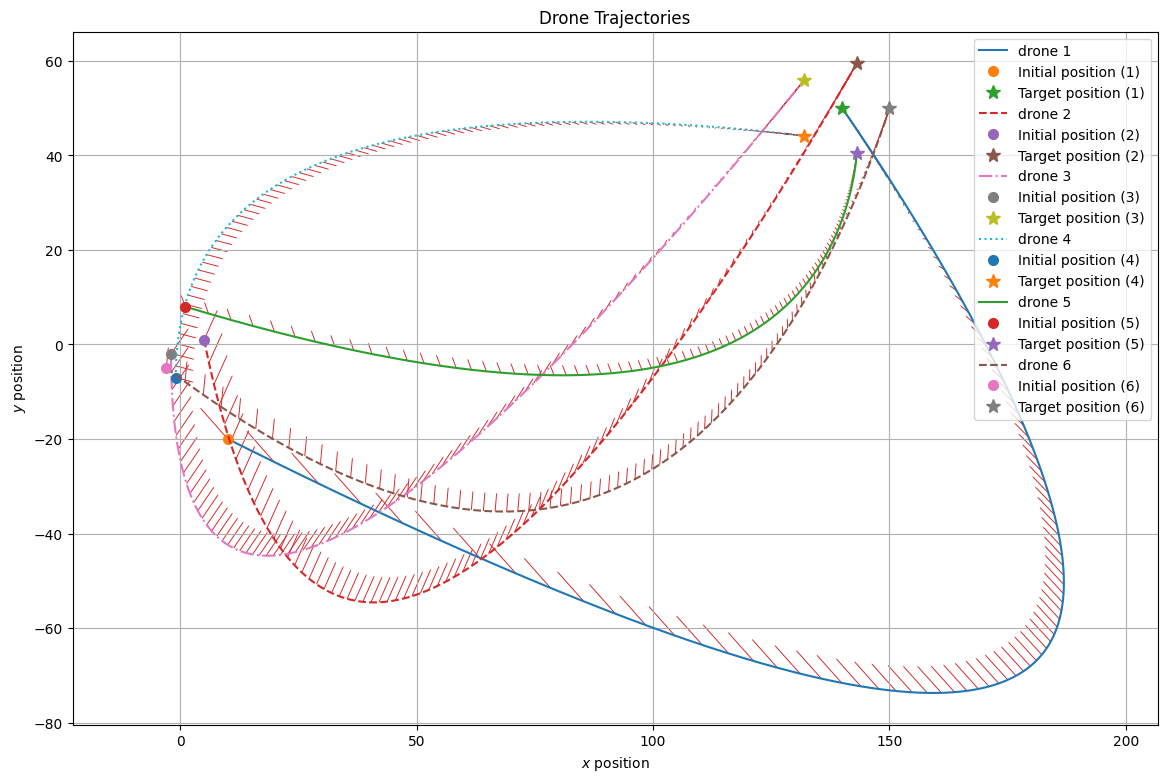

In [6]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}

x2 = cp.Variable((4,N+1))
u2 = cp.Variable((2,N))

x3 = cp.Variable((4,N+1))
u3 = cp.Variable((2,N))

x4 = cp.Variable((4,N+1))
u4 = cp.Variable((2,N))

x5 = cp.Variable((4,N+1))
u5 = cp.Variable((2,N))

x6 = cp.Variable((4,N+1))
u6 = cp.Variable((2,N))

u_lb = np.array([-1, -1])*0.7
u_ub = np.array([ 1,  1])*0.7

v_lb = np.array([-1, -1])*1000
v_ub = np.array([ 1,  1])*1000
D = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x1_0 = np.array([10, -20, 20, -10])
x1_des = np.array([140, 50, 0, 0])

r = 10
r0 = 10
v0 = 10

np.random.seed(142857)
random.seed(142857)

x2_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
x3_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
x4_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
x5_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
x6_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])

x2_des = x1_des + np.array([r*cos(2*pi/5*1), r*sin(2*pi/5*1), 0, 0])
x3_des = x1_des + np.array([r*cos(2*pi/5*2), r*sin(2*pi/5*2), 0, 0])
x4_des = x1_des + np.array([r*cos(2*pi/5*3), r*sin(2*pi/5*3), 0, 0])
x5_des = x1_des + np.array([r*cos(2*pi/5*4), r*sin(2*pi/5*4), 0, 0])
x6_des = x1_des + np.array([r*cos(2*pi/5*5), r*sin(2*pi/5*5), 0, 0])

obj = cp.sum_squares(u1) + cp.sum_squares(u2) + cp.sum_squares(u3) + cp.sum_squares(u4) + cp.sum_squares(u5) + cp.sum_squares(u6)
# obj = cp.norm(cp.norm(u,2,axis=0),1)

obj = cp.Minimize(obj)

constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
           x3[:,-1] == x3_des,
           x3[:,0]  == x3_0,
           x4[:,-1] == x4_des,
           x4[:,0]  == x4_0,
           x5[:,-1] == x5_des,
           x5[:,0]  == x5_0,
           x6[:,-1] == x6_des,
           x6[:,0]  == x6_0    ]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
    constr += [ x3[:,t+1] == A@x3[:,t] + B@u3[:,t] ]
    constr += [ x4[:,t+1] == A@x4[:,t] + B@u4[:,t] ]
    constr += [ x5[:,t+1] == A@x5[:,t] + B@u5[:,t] ]
    constr += [ x6[:,t+1] == A@x6[:,t] + B@u6[:,t] ]
    # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]
    constr += [ u_lb <= u2[:,t], u2[:,t] <= u_ub ]
    constr += [ u_lb <= u3[:,t], u3[:,t] <= u_ub ]
    constr += [ u_lb <= u4[:,t], u4[:,t] <= u_ub ]
    constr += [ u_lb <= u5[:,t], u5[:,t] <= u_ub ]
    constr += [ u_lb <= u6[:,t], u6[:,t] <= u_ub ]

    # constr += [ v_lb <= D@x1[:,t], D@x1[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x2[:,t], D@x2[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x3[:,t], D@x3[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x4[:,t], D@x4[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x5[:,t], D@x5[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x6[:,t], D@x6[:,t] <= v_ub ]

cp.Problem(obj, constr).solve(verbose=True)

x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)
x3_cp = np.array(x3.value)
u3_cp = np.array(u3.value)
x4_cp = np.array(x4.value)
u4_cp = np.array(u4.value)
x5_cp = np.array(x5.value)
u5_cp = np.array(u5.value)
x6_cp = np.array(x6.value)
u6_cp = np.array(u6.value)

x_cps = [x1_cp, x2_cp, x3_cp, x4_cp, x5_cp, x6_cp]
u_cps = [u1_cp, u2_cp, u3_cp, u4_cp, u5_cp, u6_cp]
x_0s = [x1_0, x2_0, x3_0, x4_0, x5_0, x6_0]
x_dess = [x1_des, x2_des, x3_des, x4_des, x5_des, x6_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 09 08:53:44 PM: Your problem has 36024 variables, 72048 constraints, and 0 parameters.
(CVXPY) May 09 08:53:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 08:53:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 08:53:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 09 08:53:46 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 09 08:53:48 PM: Compiling problem (target solver=OSQP

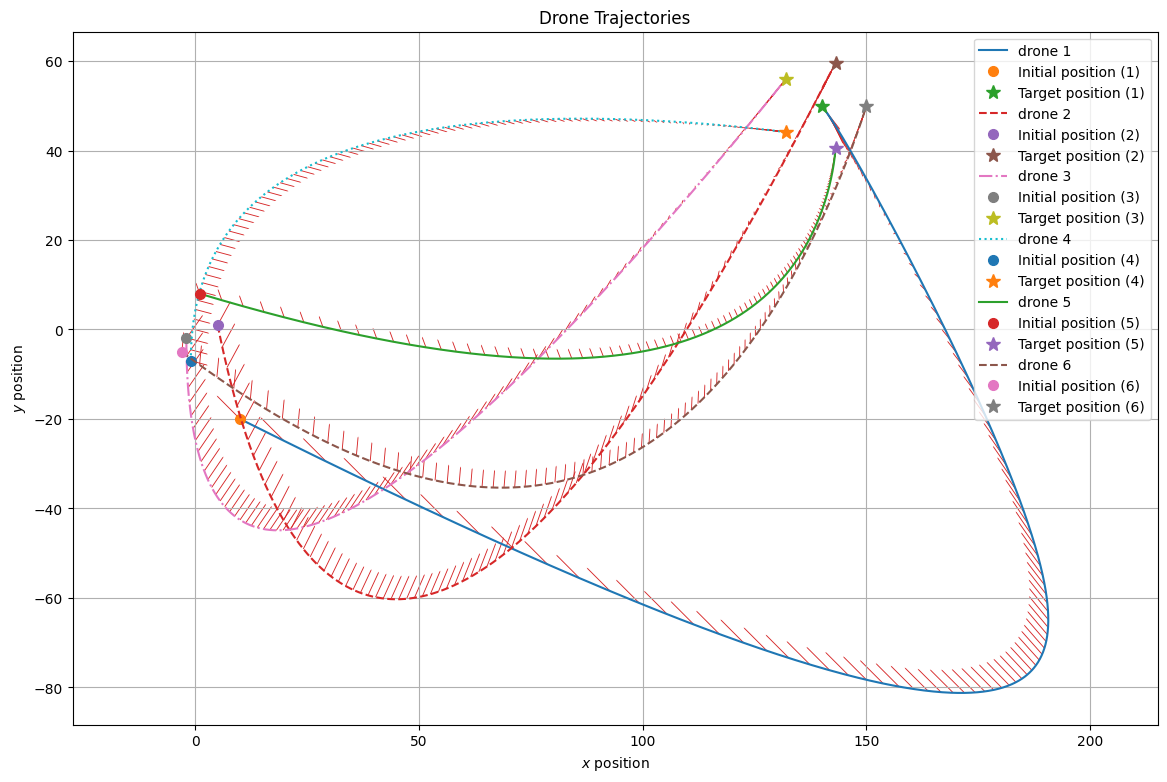

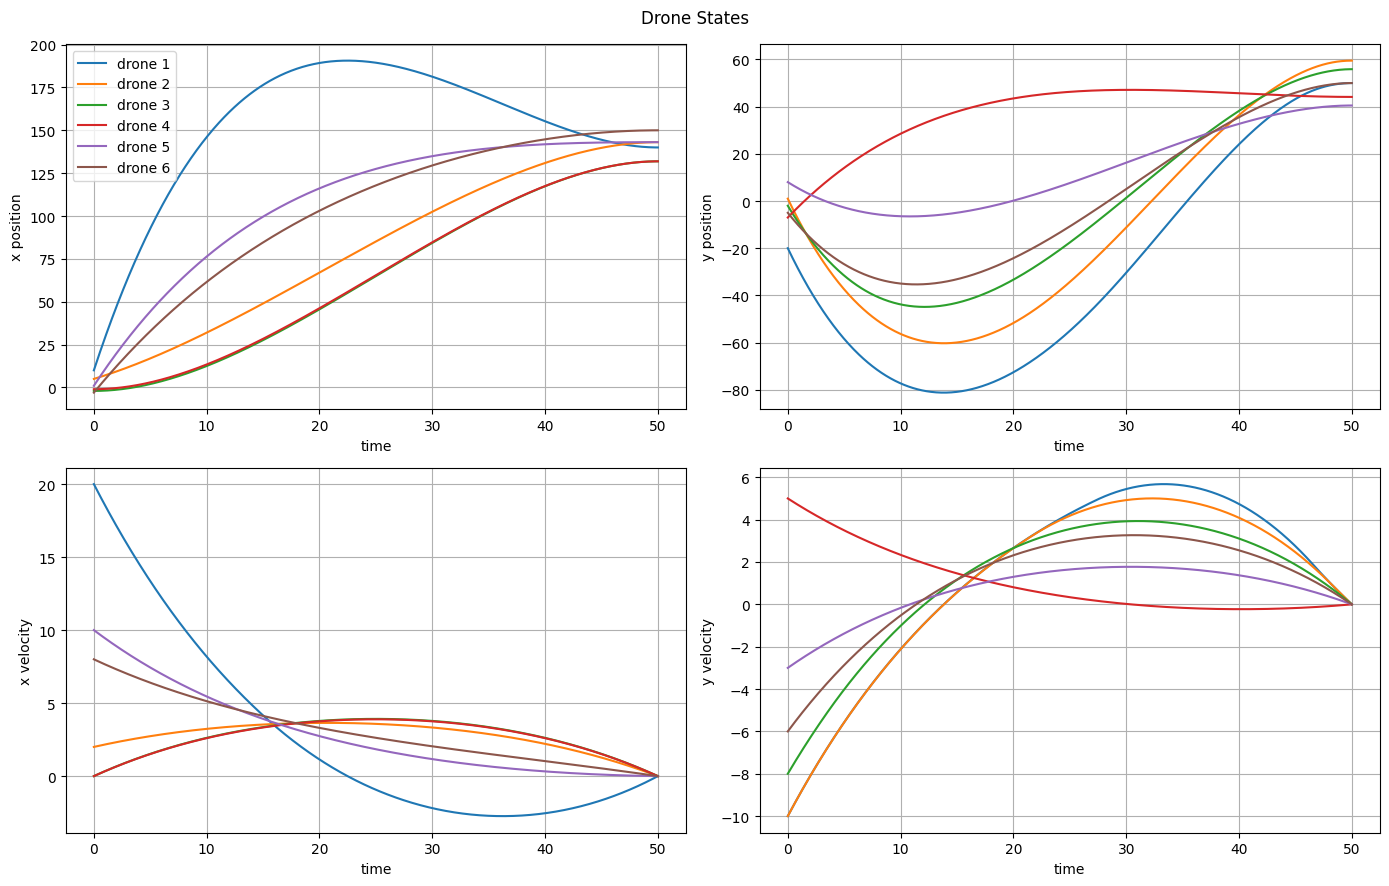

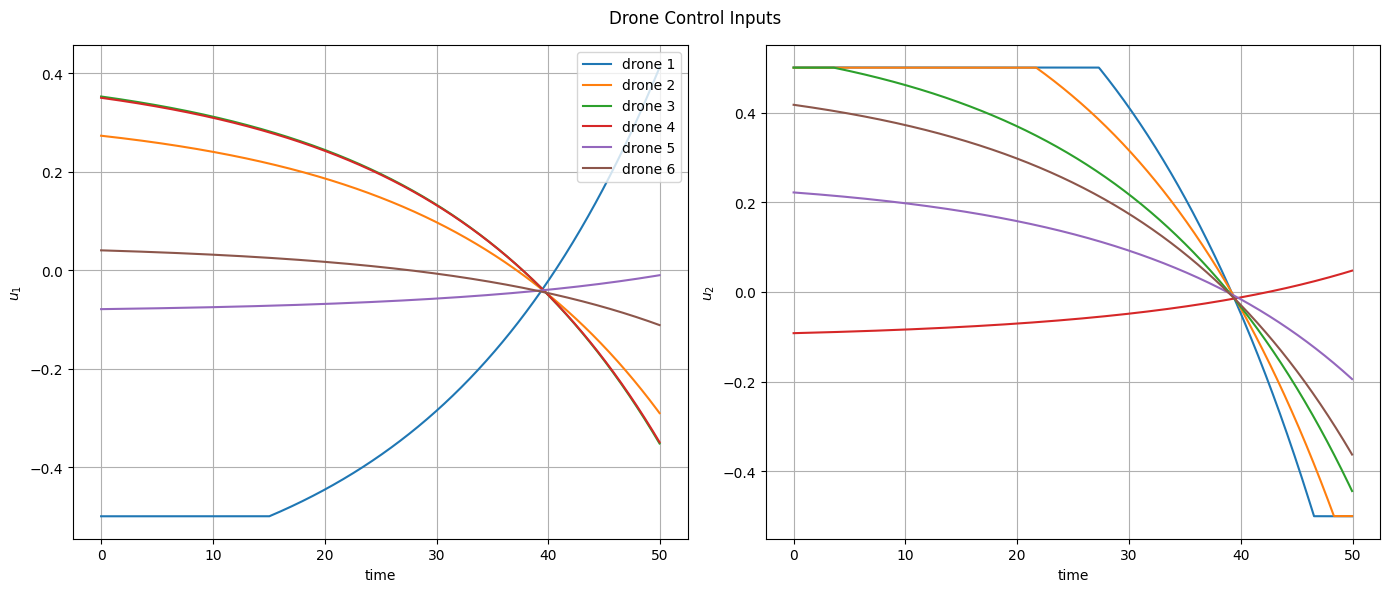

In [ ]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}

x2 = cp.Variable((4,N+1))
u2 = cp.Variable((2,N))

x3 = cp.Variable((4,N+1))
u3 = cp.Variable((2,N))

x4 = cp.Variable((4,N+1))
u4 = cp.Variable((2,N))

x5 = cp.Variable((4,N+1))
u5 = cp.Variable((2,N))

x6 = cp.Variable((4,N+1))
u6 = cp.Variable((2,N))

u_lb = np.array([-1, -1])*0.5
u_ub = np.array([ 1,  1])*0.5

v_lb = np.array([-1, -1])*20
v_ub = np.array([ 1,  1])*20
D = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x1_0 = np.array([10, -20, 20, -10])
x1_des = np.array([140, 50, 0, 0])

r = 10
r0 = 10
v0 = 10

np.random.seed(142857)
random.seed(142857)

x2_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
x3_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
x4_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
x5_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
x6_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])

x2_des = x1_des + np.array([r*cos(2*pi/5*1), r*sin(2*pi/5*1), 0, 0])
x3_des = x1_des + np.array([r*cos(2*pi/5*2), r*sin(2*pi/5*2), 0, 0])
x4_des = x1_des + np.array([r*cos(2*pi/5*3), r*sin(2*pi/5*3), 0, 0])
x5_des = x1_des + np.array([r*cos(2*pi/5*4), r*sin(2*pi/5*4), 0, 0])
x6_des = x1_des + np.array([r*cos(2*pi/5*5), r*sin(2*pi/5*5), 0, 0])

obj = cp.sum_squares(u1) + cp.sum_squares(u2) + cp.sum_squares(u3) + cp.sum_squares(u4) + cp.sum_squares(u5) + cp.sum_squares(u6)
# obj = cp.norm(cp.norm(u,2,axis=0),1)

obj = cp.Minimize(obj)

constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
           x3[:,-1] == x3_des,
           x3[:,0]  == x3_0,
           x4[:,-1] == x4_des,
           x4[:,0]  == x4_0,
           x5[:,-1] == x5_des,
           x5[:,0]  == x5_0,
           x6[:,-1] == x6_des,
           x6[:,0]  == x6_0    ]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
    constr += [ x3[:,t+1] == A@x3[:,t] + B@u3[:,t] ]
    constr += [ x4[:,t+1] == A@x4[:,t] + B@u4[:,t] ]
    constr += [ x5[:,t+1] == A@x5[:,t] + B@u5[:,t] ]
    constr += [ x6[:,t+1] == A@x6[:,t] + B@u6[:,t] ]
    # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]
    constr += [ u_lb <= u2[:,t], u2[:,t] <= u_ub ]
    constr += [ u_lb <= u3[:,t], u3[:,t] <= u_ub ]
    constr += [ u_lb <= u4[:,t], u4[:,t] <= u_ub ]
    constr += [ u_lb <= u5[:,t], u5[:,t] <= u_ub ]
    constr += [ u_lb <= u6[:,t], u6[:,t] <= u_ub ]

    constr += [ v_lb <= D@x1[:,t], D@x1[:,t] <= v_ub ]
    constr += [ v_lb <= D@x2[:,t], D@x2[:,t] <= v_ub ]
    constr += [ v_lb <= D@x3[:,t], D@x3[:,t] <= v_ub ]
    constr += [ v_lb <= D@x4[:,t], D@x4[:,t] <= v_ub ]
    constr += [ v_lb <= D@x5[:,t], D@x5[:,t] <= v_ub ]
    constr += [ v_lb <= D@x6[:,t], D@x6[:,t] <= v_ub ]

cp.Problem(obj, constr).solve(verbose=True)

x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)
x3_cp = np.array(x3.value)
u3_cp = np.array(u3.value)
x4_cp = np.array(x4.value)
u4_cp = np.array(u4.value)
x5_cp = np.array(x5.value)
u5_cp = np.array(u5.value)
x6_cp = np.array(x6.value)
u6_cp = np.array(u6.value)

x_cps = [x1_cp, x2_cp, x3_cp, x4_cp, x5_cp, x6_cp]
u_cps = [u1_cp, u2_cp, u3_cp, u4_cp, u5_cp, u6_cp]
x_0s = [x1_0, x2_0, x3_0, x4_0, x5_0, x6_0]
x_dess = [x1_des, x2_des, x3_des, x4_des, x5_des, x6_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)
plot_drone_states_controls(x_cps, u_cps, ts)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 12 08:38:06 PM: Your problem has 12008 variables, 10016 constraints, and 0 parameters.
(CVXPY) May 12 08:38:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 08:38:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 08:38:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 12 08:38:06 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 08:38:07 PM: Compiling problem (target solver=ECOS

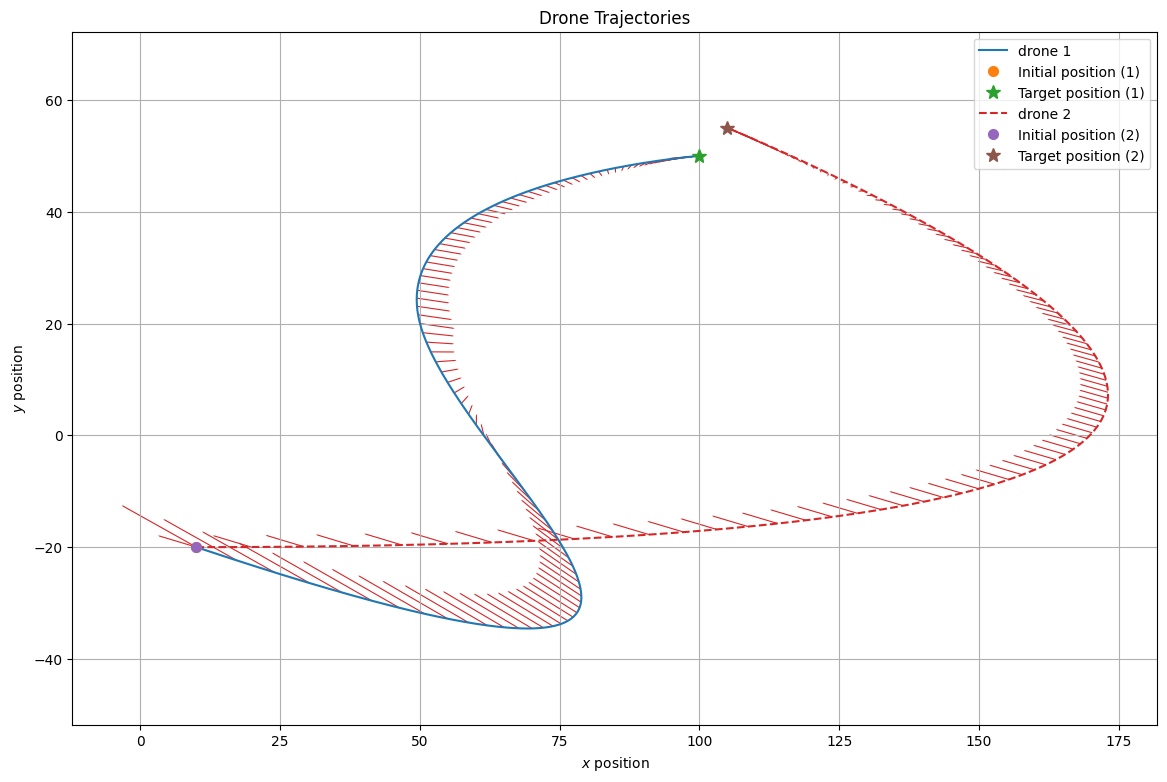

In [47]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}

x2 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u2 = cp.Variable((2,N))    # u_{0},...,u_{N-1}

u_lb = np.array([-1, -1])*0.7
u_ub = np.array([ 1,  1])*0.7

u_dot_ub = 0.3

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x1_0 = np.array([10, -20, 15, -5])
x2_0 = x1_0 + np.array([0, 0, 5, 5])

x1_wpt1 = np.array([50, 20, 5, 5])

x1_des = np.array([100, 50, 0, 0])
x2_des = x1_des + np.array([5, 5, 0, 0])

obj = cp.sum_squares(u1) + cp.sum_squares(u2)
# obj = cp.norm(cp.norm(u,2,axis=0),1)

obj = cp.Minimize(obj)

constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
           x1[:2, int(N/2)] == C@x1_wpt1]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
    if t == N-1:
        continue
    constr += [ cp.norm(u1[:, t+1] - u1[:, t]) <= u_dot_ub ]
    constr += [ cp.norm(u2[:, t+1] - u2[:, t]) <= u_dot_ub ]
    
    # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]

# cp.Problem(obj, constr).solve(verbose=True)
cp.Problem(obj, constr).solve(solver=cp.ECOS, verbose=True)


x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)

x_cps = [x1_cp, x2_cp]
u_cps = [u1_cp, u2_cp]
x_0s = [x1_0, x2_0]
x_dess = [x1_des, x2_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)

# SCP

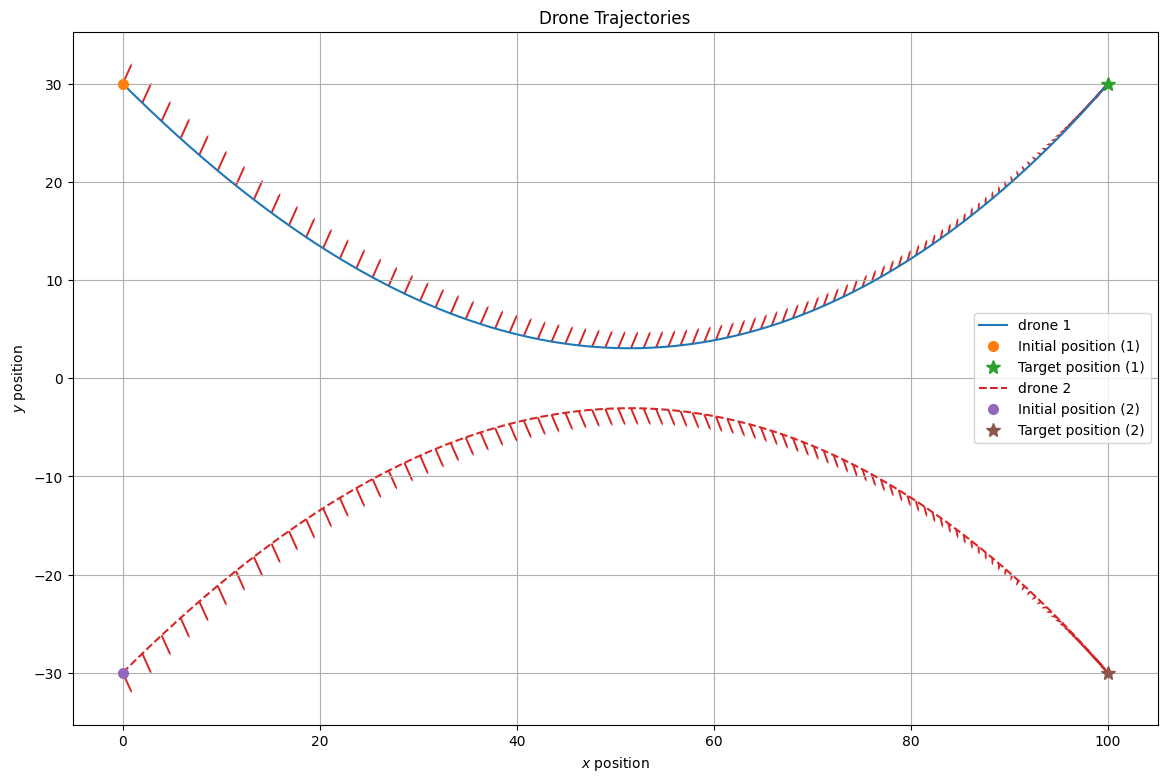

In [15]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}
x2 = cp.Variable((4,N+1))
u2 = cp.Variable((2,N))
# x3 = cp.Variable((4,N+1))
# u3 = cp.Variable((2,N))
# x4 = cp.Variable((4,N+1))
# u4 = cp.Variable((2,N))
# x5 = cp.Variable((4,N+1))
# u5 = cp.Variable((2,N))
# x6 = cp.Variable((4,N+1))
# u6 = cp.Variable((2,N))

u_lb = np.array([-1, -1])*0.5
u_ub = np.array([ 1,  1])*0.5

v_lb = np.array([-1, -1])*20
v_ub = np.array([ 1,  1])*20
D = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

# x1_0 = np.array([10, -20, 20, -10])
# x1_des = np.array([140, 50, 0, 0])

# r = 10
# r0 = 10
# v0 = 10

x1_0 = np.array([0, 30, 10, -5])
x2_0 = np.array([0, -30, 10, 5])

x1_des = np.array([100, -30, 0, 0])
x2_des = np.array([100, 30, 0, 0])


x1_0 = np.array([0, 30, 4, -4])
x2_0 = np.array([0, -30, 4, 4])

x1_des = np.array([100, 30, 0, 0])
x2_des = np.array([100, -30, 0, 0])

# np.random.seed(142857)
# random.seed(142857)

# x2_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
# x3_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
# x4_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
# x5_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
# x6_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])

# x2_des = x1_des + np.array([r*cos(2*pi/5*1), r*sin(2*pi/5*1), 0, 0])
# x3_des = x1_des + np.array([r*cos(2*pi/5*2), r*sin(2*pi/5*2), 0, 0])
# x4_des = x1_des + np.array([r*cos(2*pi/5*3), r*sin(2*pi/5*3), 0, 0])
# x5_des = x1_des + np.array([r*cos(2*pi/5*4), r*sin(2*pi/5*4), 0, 0])
# x6_des = x1_des + np.array([r*cos(2*pi/5*5), r*sin(2*pi/5*5), 0, 0])

obj = cp.sum_squares(u1) + cp.sum_squares(u2) #+ cp.sum_squares(u3) + cp.sum_squares(u4) + cp.sum_squares(u5) + cp.sum_squares(u6)
# obj = cp.norm(cp.norm(u,2,axis=0),1)

obj = cp.Minimize(obj)

x1_cp_hist = []
u1_cp_hist = []   
x2_cp_hist = []
u2_cp_hist = []   
# x3_cp_hist = []
# u3_cp_hist = []   
# x4_cp_hist = []
# u4_cp_hist = []   
# x5_cp_hist = []
# u5_cp_hist = []   
# x6_cp_hist = []
# u6_cp_hist = []   


constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
        #    x3[:,-1] == x3_des,
        #    x3[:,0]  == x3_0,
        #    x4[:,-1] == x4_des,
        #    x4[:,0]  == x4_0,
        #    x5[:,-1] == x5_des,
        #    x5[:,0]  == x5_0,
        #    x6[:,-1] == x6_des,
        #    x6[:,0]  == x6_0    
           ]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
    # constr += [ x3[:,t+1] == A@x3[:,t] + B@u3[:,t] ]
    # constr += [ x4[:,t+1] == A@x4[:,t] + B@u4[:,t] ]
    # constr += [ x5[:,t+1] == A@x5[:,t] + B@u5[:,t] ]
    # constr += [ x6[:,t+1] == A@x6[:,t] + B@u6[:,t] ]
    # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    
    # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]
    # constr += [ u_lb <= u2[:,t], u2[:,t] <= u_ub ]
    # constr += [ u_lb <= u3[:,t], u3[:,t] <= u_ub ]
    # constr += [ u_lb <= u4[:,t], u4[:,t] <= u_ub ]
    # constr += [ u_lb <= u5[:,t], u5[:,t] <= u_ub ]
    # constr += [ u_lb <= u6[:,t], u6[:,t] <= u_ub ]

    # constr += [ v_lb <= D@x1[:,t], D@x1[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x2[:,t], D@x2[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x3[:,t], D@x3[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x4[:,t], D@x4[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x5[:,t], D@x5[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x6[:,t], D@x6[:,t] <= v_ub ]

cp.Problem(obj, constr).solve(verbose=False)

x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)
# x3_cp = np.array(x3.value)
# u3_cp = np.array(u3.value)
# x4_cp = np.array(x4.value)
# u4_cp = np.array(u4.value)
# x5_cp = np.array(x5.value)
# u5_cp = np.array(u5.value)
# x6_cp = np.array(x6.value)
# u6_cp = np.array(u6.value)

x1_cp_hist.append(x1_cp)
u1_cp_hist.append(u1_cp)
x2_cp_hist.append(x2_cp)
u2_cp_hist.append(u2_cp)
# x3_cp_hist.append(x3_cp)
# u3_cp_hist.append(u3_cp)
# x4_cp_hist.append(x4_cp)
# u4_cp_hist.append(u4_cp)
# x5_cp_hist.append(x5_cp)
# u5_cp_hist.append(u5_cp)
# x6_cp_hist.append(x6_cp)
# u6_cp_hist.append(u6_cp)

# x_cps = [x1_cp, x2_cp, x3_cp, x4_cp, x5_cp, x6_cp]
# u_cps = [u1_cp, u2_cp, u3_cp, u4_cp, u5_cp, u6_cp]
# x_0s = [x1_0, x2_0, x3_0, x4_0, x5_0, x6_0]
# x_dess = [x1_des, x2_des, x3_des, x4_des, x5_des, x6_des]

x_cps = [x1_cp, x2_cp]
u_cps = [u1_cp, u2_cp]
x_0s = [x1_0, x2_0]
x_dess = [x1_des, x2_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)
# plot_drone_states_controls(x_cps, u_cps, ts)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 09 10:36:43 PM: Your problem has 12008 variables, 9016 constraints, and 0 parameters.
(CVXPY) May 09 10:36:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 10:36:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 10:36:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 09 10:36:43 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 09 10:36:44 PM: Compiling problem (target solver=OSQP)

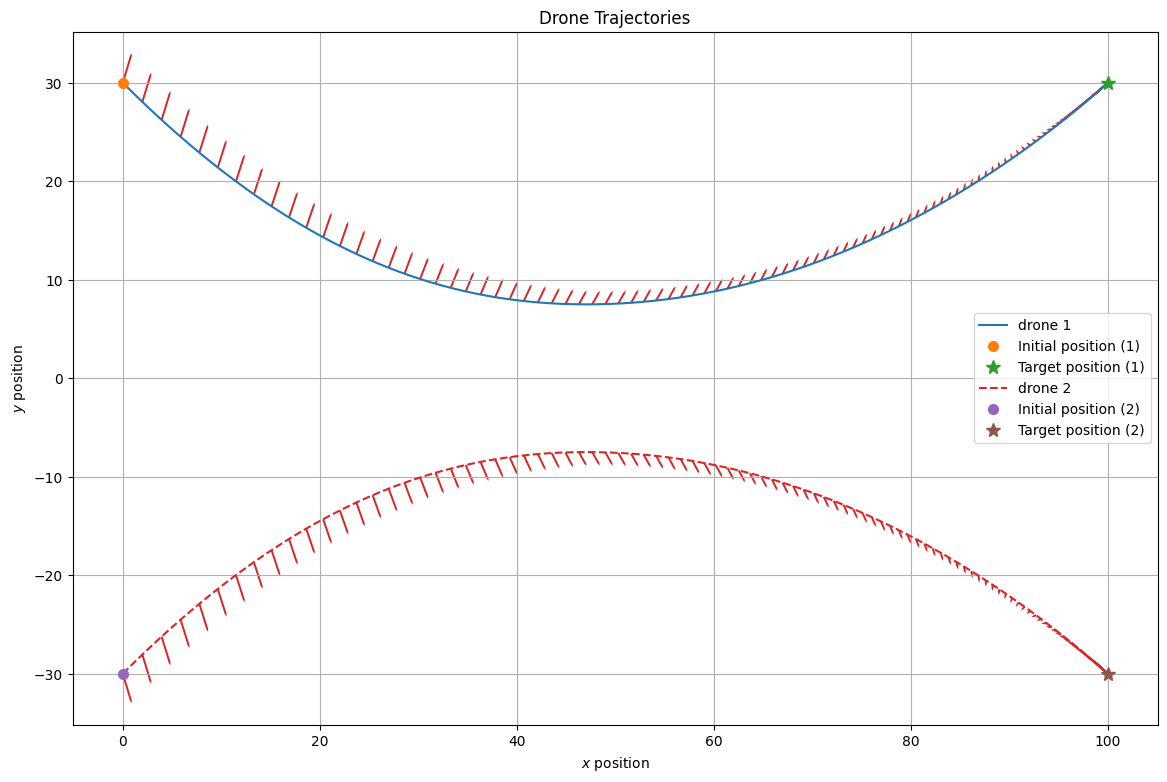

In [16]:
max_iters = 10

##########################
# p_obs = np.array([120,20])
d_sft = 15
# u_lb = 0.1
##########################

for iter in range(max_iters):
    x1_ref = x1_cp
    x2_ref = x2_cp
    # x3_ref = x3_cp
    # x4_ref = x4_cp
    # x5_ref = x5_cp
    # x6_ref = x6_cp
    
    u1_ref = u1_cp
    u2_ref = u2_cp
    # u3_ref = u3_cp
    # u4_ref = u4_cp
    # u5_ref = u5_cp
    # u6_ref = u6_cp
    
    # Trust region
    # alpha = 0.5  # damping factor
    # x1_ref = alpha * x1_cp + (1 - alpha) * x1_ref
    # x2_ref = alpha * x2_cp + (1 - alpha) * x2_ref

    
    obj = cp.sum_squares(u1) + cp.sum_squares(u2) #+ cp.sum_squares(u3) + cp.sum_squares(u4) + cp.sum_squares(u5) + cp.sum_squares(u6)
    obj = cp.Minimize(obj)
    
    constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
        #    x3[:,-1] == x3_des,
        #    x3[:,0]  == x3_0,
        #    x4[:,-1] == x4_des,
        #    x4[:,0]  == x4_0,
        #    x5[:,-1] == x5_des,
        #    x5[:,0]  == x5_0,
        #    x6[:,-1] == x6_des,
        #    x6[:,0]  == x6_0    
           ]
    for t in range(N):
        constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
        constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
        # constr += [ x3[:,t+1] == A@x3[:,t] + B@u3[:,t] ]
        # constr += [ x4[:,t+1] == A@x4[:,t] + B@u4[:,t] ]
        # constr += [ x5[:,t+1] == A@x5[:,t] + B@u5[:,t] ]
        # constr += [ x6[:,t+1] == A@x6[:,t] + B@u6[:,t] ]
        
        constr += [2 * (x1_ref[:2, t] - x2_ref[:2, t]).T @ (x1[:2, t] - x2[:2, t]) >= d_sft**2 + cp.sum_squares(x1_ref[:2, t] - x2_ref[:2, t])]
        
        # constr += [ 2*(x1_ref[:2,t] - x2_ref[:2,t]).T@x1[:2,t] >= d_sft**2 
        #         + cp.sum_squares(x1_ref[:2,t]) - cp.sum_squares(x2_ref[:2,t]) ]
        # constr += [ 2*(x2_ref[:2,t] - x1_ref[:2,t]).T@x2[:2,t] >= d_sft**2 
        #         + cp.sum_squares(x2_ref[:2,t]) - cp.sum_squares(x1_ref[:2,t]) ]
        # constr += [ 2*u0[:,t].T@u[:,t] >= u_lb**2 + u0[:,t].dot(u0[:,t]) ]
        
        # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
        
        # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]
        # constr += [ u_lb <= u2[:,t], u2[:,t] <= u_ub ]
        # constr += [ u_lb <= u3[:,t], u3[:,t] <= u_ub ]
        # constr += [ u_lb <= u4[:,t], u4[:,t] <= u_ub ]
        # constr += [ u_lb <= u5[:,t], u5[:,t] <= u_ub ]
        # constr += [ u_lb <= u6[:,t], u6[:,t] <= u_ub ]

        # constr += [ v_lb <= D@x1[:,t], D@x1[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x2[:,t], D@x2[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x3[:,t], D@x3[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x4[:,t], D@x4[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x5[:,t], D@x5[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x6[:,t], D@x6[:,t] <= v_ub ]

    # cp.Problem(obj, constr).solve(solver=cp.SCS, verbose=True)
    cp.Problem(obj, constr).solve(verbose=True)

    x1_cp = np.array(x1.value)
    u1_cp = np.array(u1.value)
    x2_cp = np.array(x2.value)
    u2_cp = np.array(u2.value)
    # x3_cp = np.array(x3.value)
    # u3_cp = np.array(u3.value)
    # x4_cp = np.array(x4.value)
    # u4_cp = np.array(u4.value)
    # x5_cp = np.array(x5.value)
    # u5_cp = np.array(u5.value)
    # x6_cp = np.array(x6.value)
    # u6_cp = np.array(u6.value)

    x1_cp_hist.append(x1_cp)
    u1_cp_hist.append(u1_cp)
    x2_cp_hist.append(x2_cp)
    u2_cp_hist.append(u2_cp)
    # x3_cp_hist.append(x3_cp)
    # u3_cp_hist.append(u3_cp)
    # x4_cp_hist.append(x4_cp)
    # u4_cp_hist.append(u4_cp)
    # x5_cp_hist.append(x5_cp)
    # u5_cp_hist.append(u5_cp)
    # x6_cp_hist.append(x6_cp)
    # u6_cp_hist.append(u6_cp)
        
    print(iter)
    
    cond_1 = (np.linalg.norm(x1_cp_hist[-1][:2]-x1_cp_hist[-2][:2],'fro')<1.0)
    cond_2 = (np.linalg.norm(x2_cp_hist[-1][:2]-x2_cp_hist[-2][:2],'fro')<1.0)
    # cond_3 = (np.linalg.norm(x3_cp_hist[-1]-x3_cp_hist[-2],'fro')<1.0)
    # cond_4 = (np.linalg.norm(x4_cp_hist[-1]-x4_cp_hist[-2],'fro')<1.0)
    # cond_5 = (np.linalg.norm(x5_cp_hist[-1]-x5_cp_hist[-2],'fro')<1.0)
    # cond_6 = (np.linalg.norm(x6_cp_hist[-1]-x6_cp_hist[-2],'fro')<1.0)
    if cond_1 & cond_2:
        n_iters = len(x1_cp_hist)
        print(f'terminated after {iter+1} iterations')
        break
    
x_cps = [x1_cp, x2_cp]
u_cps = [u1_cp, u2_cp]
x_0s = [x1_0, x2_0]
x_dess = [x1_des, x2_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)
# plot_drone_states_controls(x_cps, u_cps, ts)

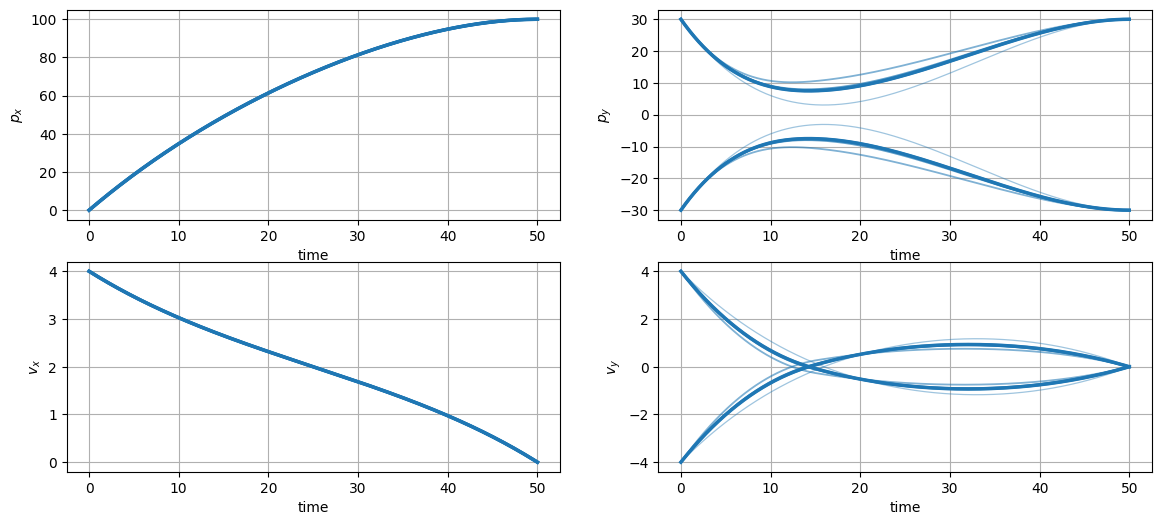

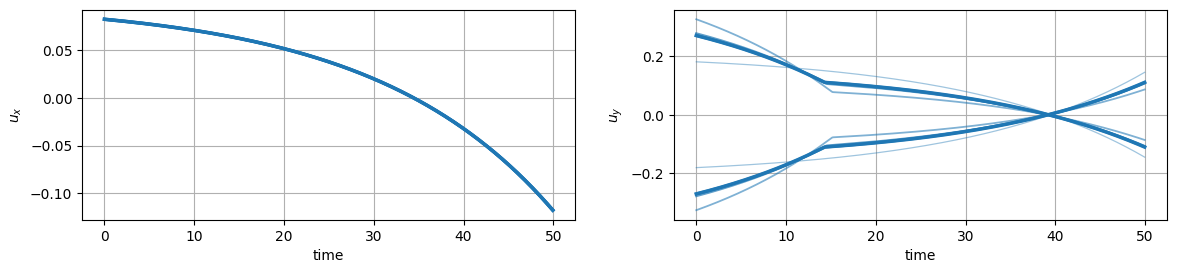

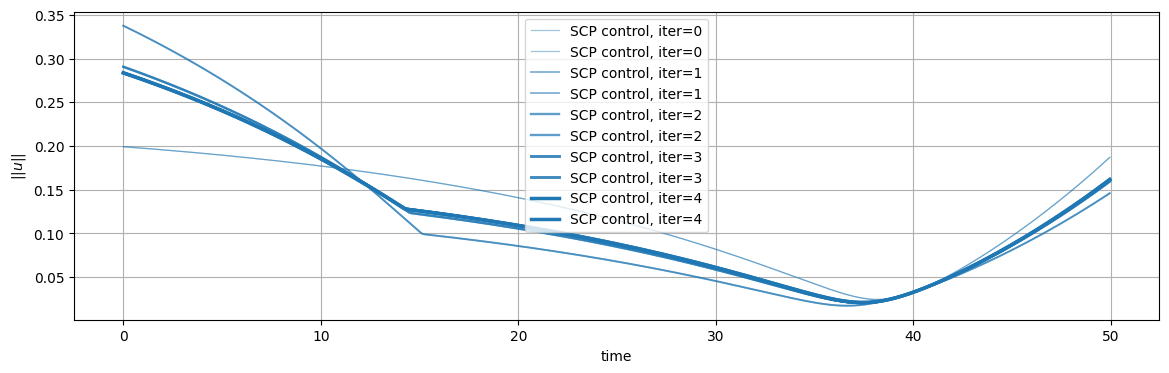

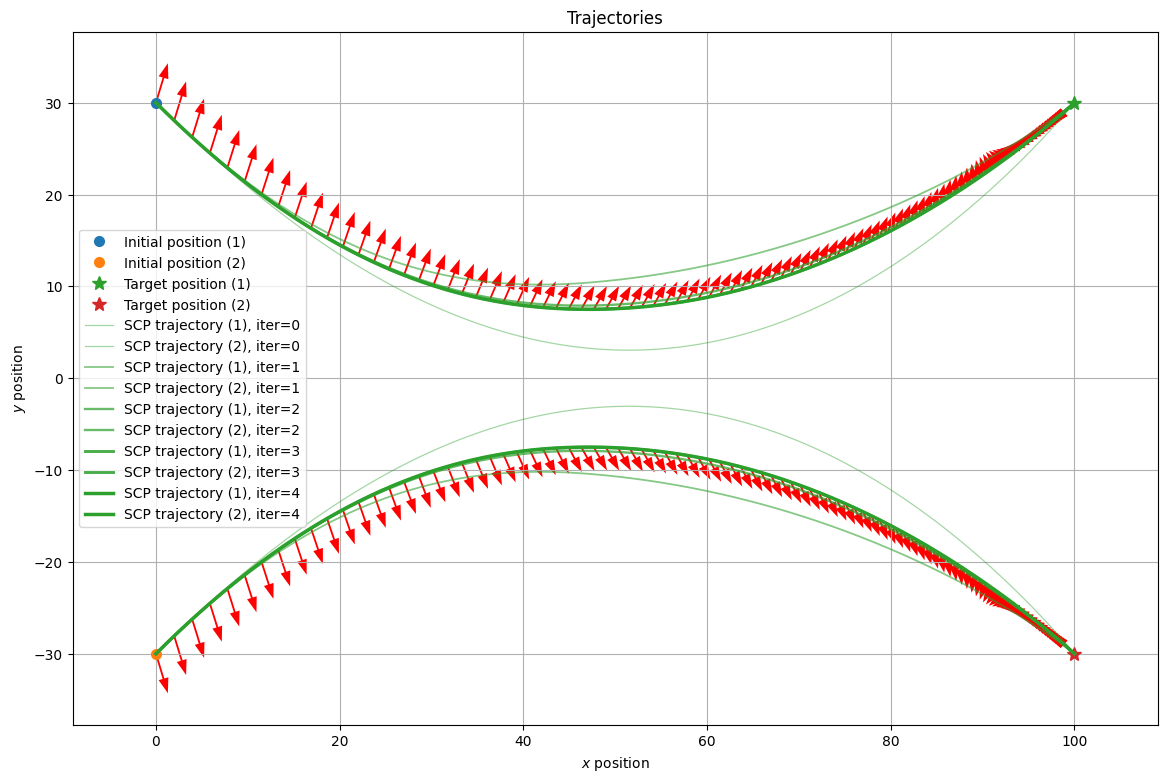

In [17]:
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_y$')
plt.grid()
plt.subplot(2,2,3)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][2,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][2,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_x$')
plt.grid()
plt.subplot(2,2,4)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][3,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][3,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_y$')
plt.grid()
plt.show()

plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts[:-1],u1_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts[:-1],u2_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts[:-1],u1_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts[:-1],u2_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_y$')
plt.grid()
plt.show()
plt.figure(figsize=(14,4), dpi=100)
for id in range(n_iters):
  plt.plot(ts[:-1],np.linalg.norm(u1_cp_hist[id],axis=0), \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
  plt.plot(ts[:-1],np.linalg.norm(u2_cp_hist[id],axis=0), \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
plt.xlabel('time')
plt.ylabel(r'$||u||$')
# plt.axhline(u_ub, color=plt.cm.tab20(2), alpha=0.5, label=r'$u_{ub}$')
# plt.axhline(u_lb, color=plt.cm.tab20(4), alpha=0.5, label=r'$u_{lb}$')
plt.legend()
plt.grid()
plt.show()

axes = plt.figure(num=1, figsize=(14,9), dpi=100)
# plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
#                 alpha = 0.1, label='Feasible region')
plt.plot(x1_0[0], x1_0[1], 'o', markersize=7, label='Initial position (1)')
plt.plot(x2_0[0], x2_0[1], 'o', markersize=7, label='Initial position (2)')
plt.plot(x1_des[0], x1_des[1], '*', markersize=10, label='Target position (1)')
plt.plot(x2_des[0], x2_des[1], '*', markersize=10, label='Target position (2)')
# plt.gca().add_artist(plt.Circle((p_obs[0],p_obs[1]),d_sft, label='Obstable', \
#                                 color=plt.cm.tab20(8), alpha=0.5))
for id in range(n_iters):
  plt.plot(x1_cp_hist[id][0,:], x1_cp_hist[id][1,:], \
           color=plt.cm.tab20(4), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory (1), iter={id}')
  plt.plot(x2_cp_hist[id][0,:], x2_cp_hist[id][1,:], \
           color=plt.cm.tab20(4), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory (2), iter={id}')

plt.legend()
plt.title('Trajectories')

for t in range(0,N,10):
  plt.arrow(x1_cp_hist[id][0,t], x1_cp_hist[id][1,t], \
            10*u1_cp_hist[id][0,t], 10*u1_cp_hist[id][1,t], \
            head_width=1.1, width=0.2, color='r', ec='none')
  plt.arrow(x2_cp_hist[id][0,t], x2_cp_hist[id][1,t], \
            10*u2_cp_hist[id][0,t], 10*u2_cp_hist[id][1,t], \
            head_width=1.1, width=0.2, color='r', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

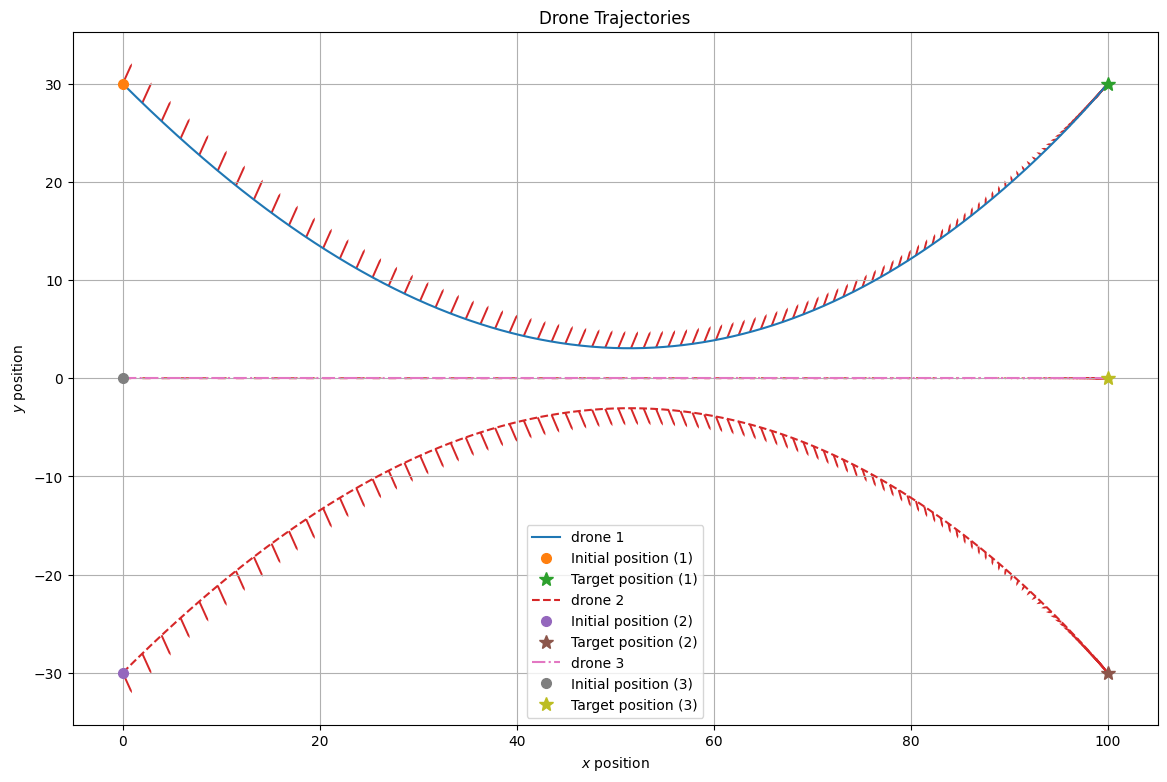

In [19]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}
x2 = cp.Variable((4,N+1))
u2 = cp.Variable((2,N))
x3 = cp.Variable((4,N+1))
u3 = cp.Variable((2,N))
# x4 = cp.Variable((4,N+1))
# u4 = cp.Variable((2,N))
# x5 = cp.Variable((4,N+1))
# u5 = cp.Variable((2,N))
# x6 = cp.Variable((4,N+1))
# u6 = cp.Variable((2,N))

u_lb = np.array([-1, -1])*0.5
u_ub = np.array([ 1,  1])*0.5

v_lb = np.array([-1, -1])*20
v_ub = np.array([ 1,  1])*20
D = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

# x1_0 = np.array([10, -20, 20, -10])
# x1_des = np.array([140, 50, 0, 0])

# r = 10
# r0 = 10
# v0 = 10

# x1_0 = np.array([0, 30, 10, -5])
# x2_0 = np.array([0, -30, 10, 5])

# x1_des = np.array([100, -30, 0, 0])
# x2_des = np.array([100, 30, 0, 0])


x1_0 = np.array([0, 30, 4, -4])
x2_0 = np.array([0, -30, 4, 4])
x3_0 = np.array([0, 0, 4, 0])

x1_des = np.array([100, 30, 0, 0])
x2_des = np.array([100, -30, 0, 0])
x3_des = np.array([100, 0, 0, 0])

# np.random.seed(142857)
# random.seed(142857)

# x2_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
# x3_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
# x4_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
# x5_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])
# x6_0 = np.array([random.randint(-r0, r0), random.randint(-r0, r0), random.randint(-v0, v0), random.randint(-v0, v0)])

# x2_des = x1_des + np.array([r*cos(2*pi/5*1), r*sin(2*pi/5*1), 0, 0])
# x3_des = x1_des + np.array([r*cos(2*pi/5*2), r*sin(2*pi/5*2), 0, 0])
# x4_des = x1_des + np.array([r*cos(2*pi/5*3), r*sin(2*pi/5*3), 0, 0])
# x5_des = x1_des + np.array([r*cos(2*pi/5*4), r*sin(2*pi/5*4), 0, 0])
# x6_des = x1_des + np.array([r*cos(2*pi/5*5), r*sin(2*pi/5*5), 0, 0])

obj = cp.sum_squares(u1) + cp.sum_squares(u2) + cp.sum_squares(u3) #+ cp.sum_squares(u4) + cp.sum_squares(u5) + cp.sum_squares(u6)
# obj = cp.norm(cp.norm(u,2,axis=0),1)

obj = cp.Minimize(obj)

x1_cp_hist = []
u1_cp_hist = []   
x2_cp_hist = []
u2_cp_hist = []   
x3_cp_hist = []
u3_cp_hist = []   
# x4_cp_hist = []
# u4_cp_hist = []   
# x5_cp_hist = []
# u5_cp_hist = []   
# x6_cp_hist = []
# u6_cp_hist = []   


constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
           x3[:,-1] == x3_des,
           x3[:,0]  == x3_0,
        #    x4[:,-1] == x4_des,
        #    x4[:,0]  == x4_0,
        #    x5[:,-1] == x5_des,
        #    x5[:,0]  == x5_0,
        #    x6[:,-1] == x6_des,
        #    x6[:,0]  == x6_0    
           ]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
    constr += [ x3[:,t+1] == A@x3[:,t] + B@u3[:,t] ]
    # constr += [ x4[:,t+1] == A@x4[:,t] + B@u4[:,t] ]
    # constr += [ x5[:,t+1] == A@x5[:,t] + B@u5[:,t] ]
    # constr += [ x6[:,t+1] == A@x6[:,t] + B@u6[:,t] ]
    # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    
    # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]
    # constr += [ u_lb <= u2[:,t], u2[:,t] <= u_ub ]
    # constr += [ u_lb <= u3[:,t], u3[:,t] <= u_ub ]
    # constr += [ u_lb <= u4[:,t], u4[:,t] <= u_ub ]
    # constr += [ u_lb <= u5[:,t], u5[:,t] <= u_ub ]
    # constr += [ u_lb <= u6[:,t], u6[:,t] <= u_ub ]

    # constr += [ v_lb <= D@x1[:,t], D@x1[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x2[:,t], D@x2[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x3[:,t], D@x3[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x4[:,t], D@x4[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x5[:,t], D@x5[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x6[:,t], D@x6[:,t] <= v_ub ]

cp.Problem(obj, constr).solve(verbose=False)

x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)
x3_cp = np.array(x3.value)
u3_cp = np.array(u3.value)
# x4_cp = np.array(x4.value)
# u4_cp = np.array(u4.value)
# x5_cp = np.array(x5.value)
# u5_cp = np.array(u5.value)
# x6_cp = np.array(x6.value)
# u6_cp = np.array(u6.value)

x1_cp_hist.append(x1_cp)
u1_cp_hist.append(u1_cp)
x2_cp_hist.append(x2_cp)
u2_cp_hist.append(u2_cp)
x3_cp_hist.append(x3_cp)
u3_cp_hist.append(u3_cp)
# x4_cp_hist.append(x4_cp)
# u4_cp_hist.append(u4_cp)
# x5_cp_hist.append(x5_cp)
# u5_cp_hist.append(u5_cp)
# x6_cp_hist.append(x6_cp)
# u6_cp_hist.append(u6_cp)

# x_cps = [x1_cp, x2_cp, x3_cp, x4_cp, x5_cp, x6_cp]
# u_cps = [u1_cp, u2_cp, u3_cp, u4_cp, u5_cp, u6_cp]
# x_0s = [x1_0, x2_0, x3_0, x4_0, x5_0, x6_0]
# x_dess = [x1_des, x2_des, x3_des, x4_des, x5_des, x6_des]

x_cps = [x1_cp, x2_cp, x3_cp]
u_cps = [u1_cp, u2_cp, u3_cp]
x_0s = [x1_0, x2_0, x3_0]
x_dess = [x1_des, x2_des, x3_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)
# plot_drone_states_controls(x_cps, u_cps, ts)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 09 10:42:11 PM: Your problem has 18012 variables, 15024 constraints, and 0 parameters.
(CVXPY) May 09 10:42:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 10:42:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 10:42:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 09 10:42:12 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 09 10:42:13 PM: Compiling problem (target solver=OSQP

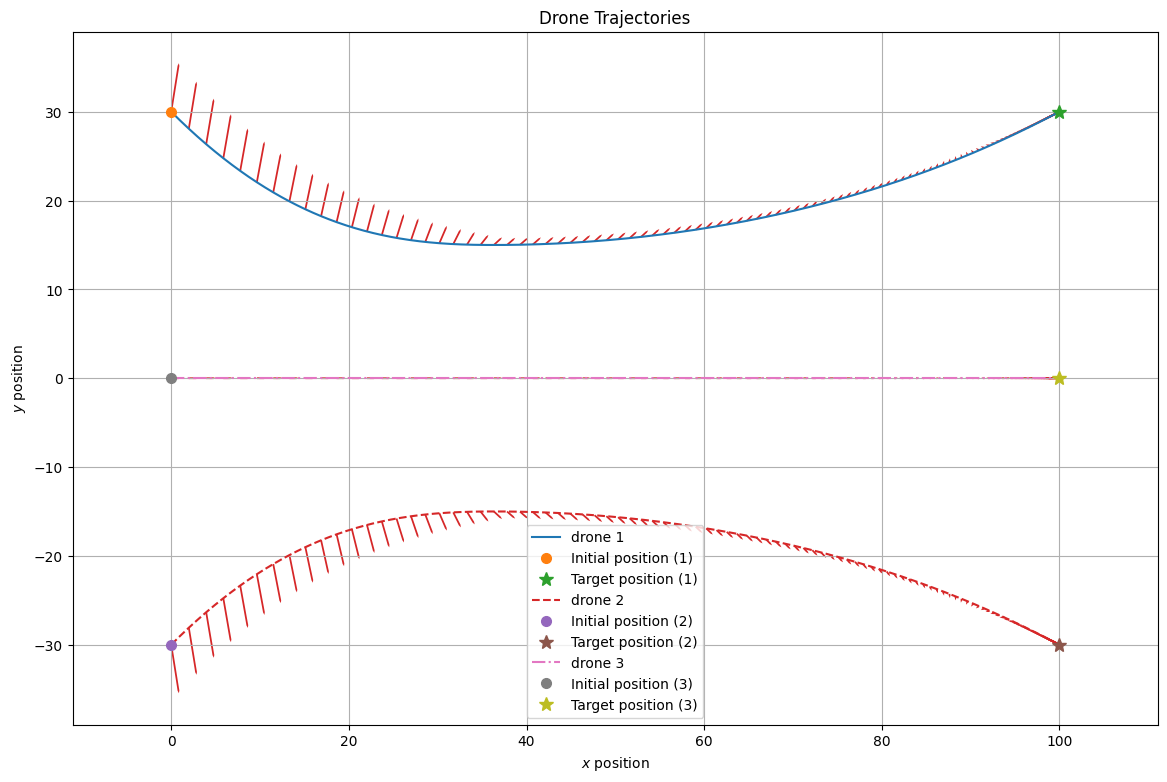

In [20]:
max_iters = 10

##########################
# p_obs = np.array([120,20])
d_sft = 15
# u_lb = 0.1
##########################

for iter in range(max_iters):
    x1_ref = x1_cp
    x2_ref = x2_cp
    x3_ref = x3_cp
    # x4_ref = x4_cp
    # x5_ref = x5_cp
    # x6_ref = x6_cp
    
    u1_ref = u1_cp
    u2_ref = u2_cp
    u3_ref = u3_cp
    # u4_ref = u4_cp
    # u5_ref = u5_cp
    # u6_ref = u6_cp
    
    # Trust region
    # alpha = 0.5  # damping factor
    # x1_ref = alpha * x1_cp + (1 - alpha) * x1_ref
    # x2_ref = alpha * x2_cp + (1 - alpha) * x2_ref

    obj = cp.sum_squares(u1) + cp.sum_squares(u2) + cp.sum_squares(u3) #+ cp.sum_squares(u4) + cp.sum_squares(u5) + cp.sum_squares(u6)
    obj = cp.Minimize(obj)
    
    constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
           x3[:,-1] == x3_des,
           x3[:,0]  == x3_0,
        #    x4[:,-1] == x4_des,
        #    x4[:,0]  == x4_0,
        #    x5[:,-1] == x5_des,
        #    x5[:,0]  == x5_0,
        #    x6[:,-1] == x6_des,
        #    x6[:,0]  == x6_0    
           ]
    for t in range(N):
        constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
        constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
        constr += [ x3[:,t+1] == A@x3[:,t] + B@u3[:,t] ]
        # constr += [ x4[:,t+1] == A@x4[:,t] + B@u4[:,t] ]
        # constr += [ x5[:,t+1] == A@x5[:,t] + B@u5[:,t] ]
        # constr += [ x6[:,t+1] == A@x6[:,t] + B@u6[:,t] ]
        
        constr += [2 * (x1_ref[:2, t] - x2_ref[:2, t]).T @ (x1[:2, t] - x2[:2, t]) >= d_sft**2 + cp.sum_squares(x1_ref[:2, t] - x2_ref[:2, t])]
        constr += [2 * (x2_ref[:2, t] - x3_ref[:2, t]).T @ (x2[:2, t] - x3[:2, t]) >= d_sft**2 + cp.sum_squares(x2_ref[:2, t] - x3_ref[:2, t])]
        constr += [2 * (x3_ref[:2, t] - x1_ref[:2, t]).T @ (x3[:2, t] - x1[:2, t]) >= d_sft**2 + cp.sum_squares(x3_ref[:2, t] - x1_ref[:2, t])]
        
        # constr += [ 2*(x1_ref[:2,t] - x2_ref[:2,t]).T@x1[:2,t] >= d_sft**2 
        #         + cp.sum_squares(x1_ref[:2,t]) - cp.sum_squares(x2_ref[:2,t]) ]
        # constr += [ 2*(x2_ref[:2,t] - x1_ref[:2,t]).T@x2[:2,t] >= d_sft**2 
        #         + cp.sum_squares(x2_ref[:2,t]) - cp.sum_squares(x1_ref[:2,t]) ]
        # constr += [ 2*u0[:,t].T@u[:,t] >= u_lb**2 + u0[:,t].dot(u0[:,t]) ]
        
        # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
        
        # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]
        # constr += [ u_lb <= u2[:,t], u2[:,t] <= u_ub ]
        # constr += [ u_lb <= u3[:,t], u3[:,t] <= u_ub ]
        # constr += [ u_lb <= u4[:,t], u4[:,t] <= u_ub ]
        # constr += [ u_lb <= u5[:,t], u5[:,t] <= u_ub ]
        # constr += [ u_lb <= u6[:,t], u6[:,t] <= u_ub ]

        # constr += [ v_lb <= D@x1[:,t], D@x1[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x2[:,t], D@x2[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x3[:,t], D@x3[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x4[:,t], D@x4[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x5[:,t], D@x5[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x6[:,t], D@x6[:,t] <= v_ub ]

    # cp.Problem(obj, constr).solve(solver=cp.SCS, verbose=True)
    cp.Problem(obj, constr).solve(verbose=True)

    x1_cp = np.array(x1.value)
    u1_cp = np.array(u1.value)
    x2_cp = np.array(x2.value)
    u2_cp = np.array(u2.value)
    x3_cp = np.array(x3.value)
    u3_cp = np.array(u3.value)
    # x4_cp = np.array(x4.value)
    # u4_cp = np.array(u4.value)
    # x5_cp = np.array(x5.value)
    # u5_cp = np.array(u5.value)
    # x6_cp = np.array(x6.value)
    # u6_cp = np.array(u6.value)

    x1_cp_hist.append(x1_cp)
    u1_cp_hist.append(u1_cp)
    x2_cp_hist.append(x2_cp)
    u2_cp_hist.append(u2_cp)
    x3_cp_hist.append(x3_cp)
    u3_cp_hist.append(u3_cp)
    # x4_cp_hist.append(x4_cp)
    # u4_cp_hist.append(u4_cp)
    # x5_cp_hist.append(x5_cp)
    # u5_cp_hist.append(u5_cp)
    # x6_cp_hist.append(x6_cp)
    # u6_cp_hist.append(u6_cp)
        
    print(iter)
    
    cond_1 = (np.linalg.norm(x1_cp_hist[-1][:2]-x1_cp_hist[-2][:2],'fro')<1.0)
    cond_2 = (np.linalg.norm(x2_cp_hist[-1][:2]-x2_cp_hist[-2][:2],'fro')<1.0)
    cond_3 = (np.linalg.norm(x3_cp_hist[-1][:2]-x3_cp_hist[-2][:2],'fro')<1.0)
    # cond_4 = (np.linalg.norm(x4_cp_hist[-1]-x4_cp_hist[-2],'fro')<1.0)
    # cond_5 = (np.linalg.norm(x5_cp_hist[-1]-x5_cp_hist[-2],'fro')<1.0)
    # cond_6 = (np.linalg.norm(x6_cp_hist[-1]-x6_cp_hist[-2],'fro')<1.0)
    if cond_1 & cond_2 & cond_3:
        n_iters = len(x1_cp_hist)
        print(f'terminated after {iter+1} iterations')
        break
    
x_cps = [x1_cp, x2_cp, x3_cp]
u_cps = [u1_cp, u2_cp, u3_cp]
x_0s = [x1_0, x2_0, x3_0]
x_dess = [x1_des, x2_des, x3_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)
# plot_drone_states_controls(x_cps, u_cps, ts)

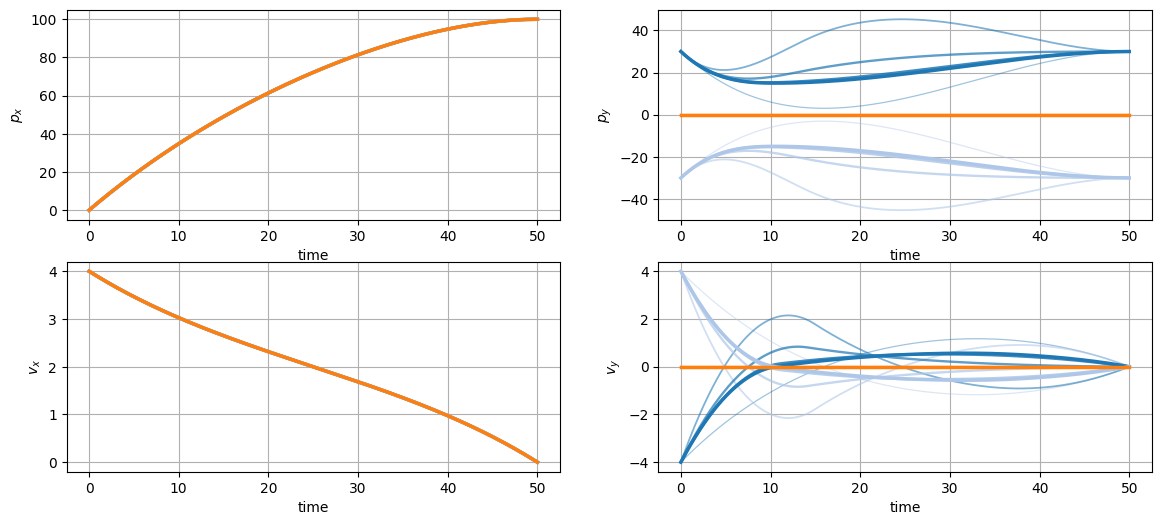

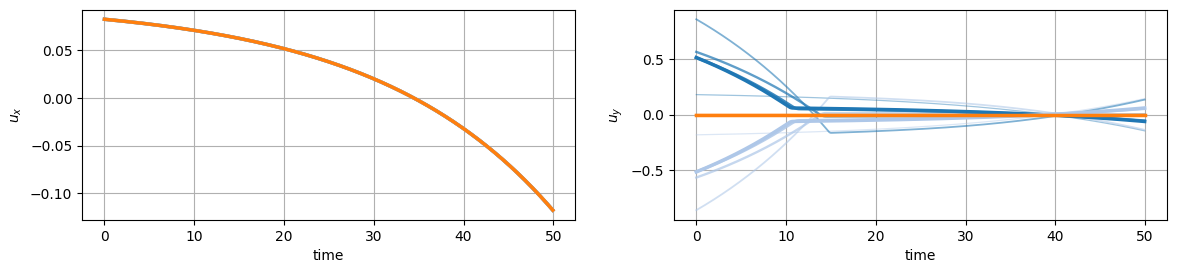

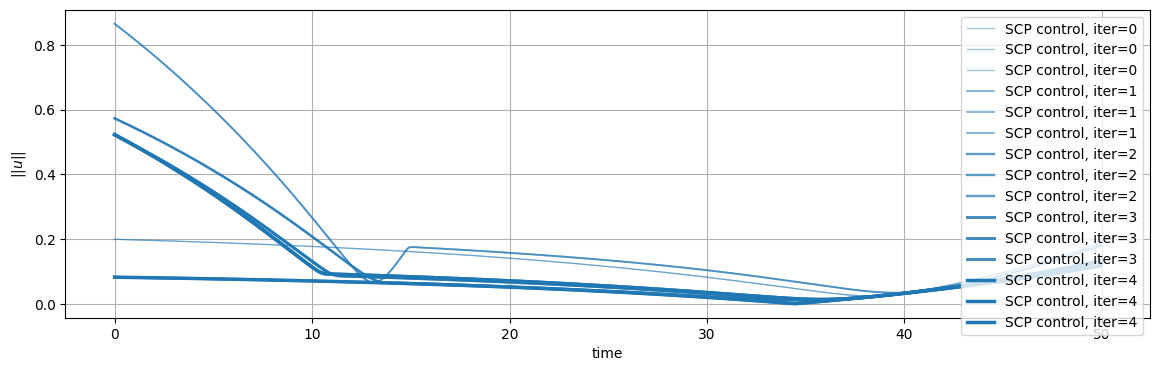

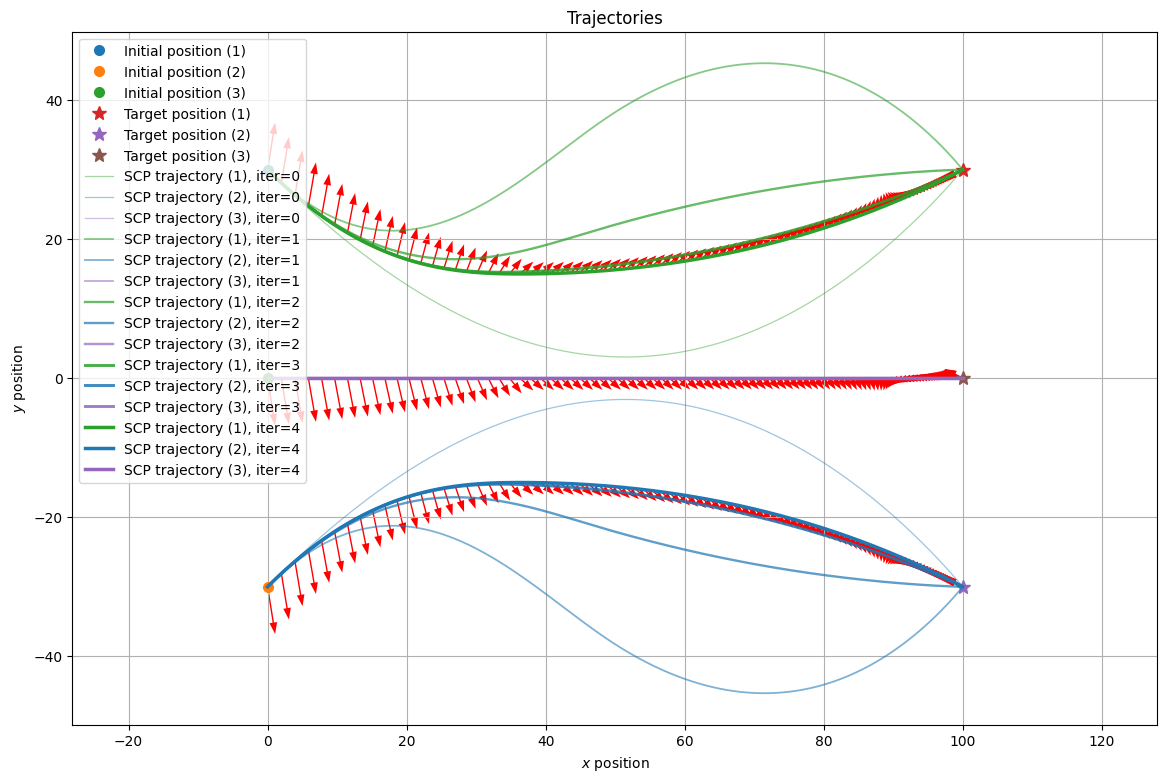

In [32]:
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][0,:], color=plt.cm.tab20(1), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x3_cp_hist[id][0,:], color=plt.cm.tab20(2), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][1,:], color=plt.cm.tab20(1), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x3_cp_hist[id][1,:], color=plt.cm.tab20(2), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_y$')
plt.grid()
plt.subplot(2,2,3)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][2,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][2,:], color=plt.cm.tab20(1), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x3_cp_hist[id][2,:], color=plt.cm.tab20(2), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_x$')
plt.grid()
plt.subplot(2,2,4)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][3,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][3,:], color=plt.cm.tab20(1), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x3_cp_hist[id][3,:], color=plt.cm.tab20(2), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_y$')
plt.grid()
plt.show()

plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts[:-1],u1_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts[:-1],u2_cp_hist[id][0,:], color=plt.cm.tab20(1), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts[:-1],u3_cp_hist[id][0,:], color=plt.cm.tab20(2), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts[:-1],u1_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts[:-1],u2_cp_hist[id][1,:], color=plt.cm.tab20(1), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts[:-1],u3_cp_hist[id][1,:], color=plt.cm.tab20(2), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_y$')
plt.grid()
plt.show()
plt.figure(figsize=(14,4), dpi=100)
for id in range(n_iters):
  plt.plot(ts[:-1],np.linalg.norm(u1_cp_hist[id],axis=0), \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
  plt.plot(ts[:-1],np.linalg.norm(u2_cp_hist[id],axis=0), \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
  plt.plot(ts[:-1],np.linalg.norm(u3_cp_hist[id],axis=0), \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
plt.xlabel('time')
plt.ylabel(r'$||u||$')
# plt.axhline(u_ub, color=plt.cm.tab20(2), alpha=0.5, label=r'$u_{ub}$')
# plt.axhline(u_lb, color=plt.cm.tab20(4), alpha=0.5, label=r'$u_{lb}$')
plt.legend()
plt.grid()
plt.show()

axes = plt.figure(num=1, figsize=(14,9), dpi=100)
# plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
#                 alpha = 0.1, label='Feasible region')
plt.plot(x1_0[0], x1_0[1], 'o', markersize=7, label='Initial position (1)')
plt.plot(x2_0[0], x2_0[1], 'o', markersize=7, label='Initial position (2)')
plt.plot(x3_0[0], x3_0[1], 'o', markersize=7, label='Initial position (3)')
plt.plot(x1_des[0], x1_des[1], '*', markersize=10, label='Target position (1)')
plt.plot(x2_des[0], x2_des[1], '*', markersize=10, label='Target position (2)')
plt.plot(x3_des[0], x3_des[1], '*', markersize=10, label='Target position (3)')
# plt.gca().add_artist(plt.Circle((p_obs[0],p_obs[1]),d_sft, label='Obstable', \
#                                 color=plt.cm.tab20(8), alpha=0.5))
for id in range(n_iters):
  plt.plot(x1_cp_hist[id][0,:], x1_cp_hist[id][1,:], \
           color=plt.cm.tab20(4), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory (1), iter={id}')
  plt.plot(x2_cp_hist[id][0,:], x2_cp_hist[id][1,:], \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory (2), iter={id}')
  plt.plot(x3_cp_hist[id][0,:], x3_cp_hist[id][1,:], \
           color=plt.cm.tab20(8), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory (3), iter={id}')

plt.legend()
plt.title('Trajectories')

for t in range(0,N,10):
  plt.arrow(x1_cp_hist[id][0,t], x1_cp_hist[id][1,t], \
            10*u1_cp_hist[id][0,t], 10*u1_cp_hist[id][1,t], \
            head_width=1.1, width=0.2, color='r', ec='none')
  plt.arrow(x2_cp_hist[id][0,t], x2_cp_hist[id][1,t], \
            10*u2_cp_hist[id][0,t], 10*u2_cp_hist[id][1,t], \
            head_width=1.1, width=0.2, color='r', ec='none')
  plt.arrow(x3_cp_hist[id][0,t], x3_cp_hist[id][1,t], \
            10*u2_cp_hist[id][0,t], 10*u2_cp_hist[id][1,t], \
            head_width=1.1, width=0.2, color='r', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

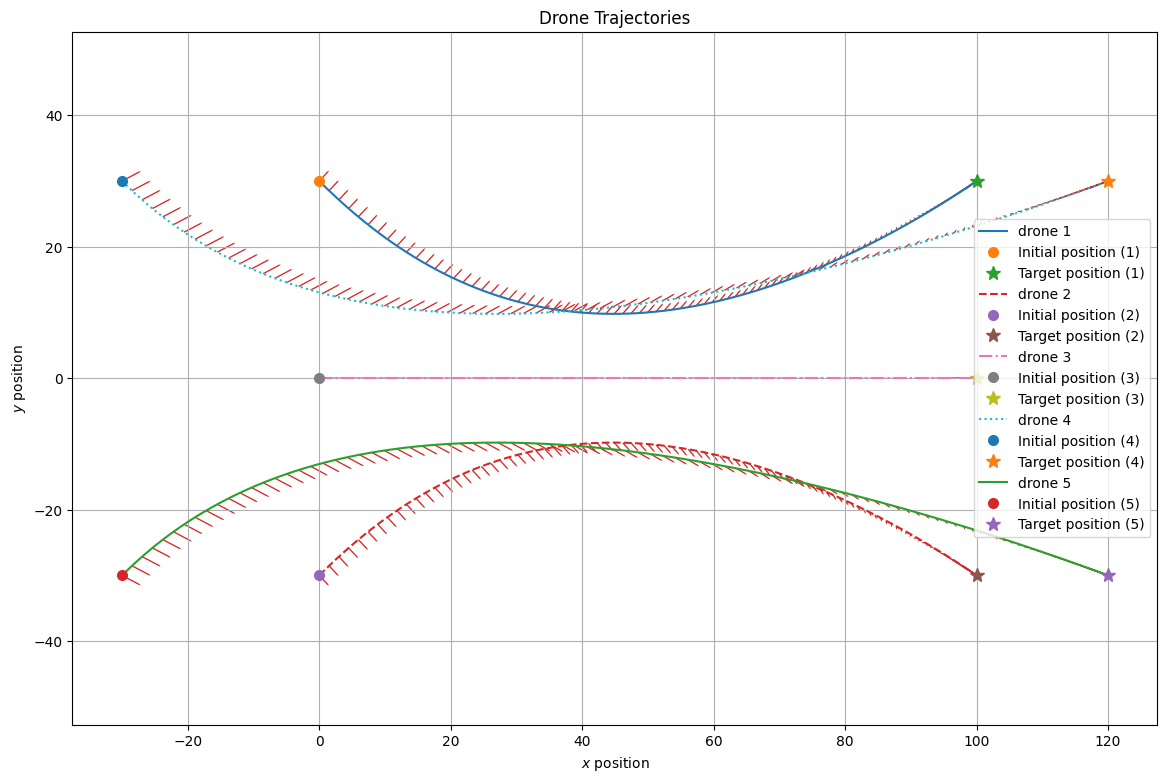

In [4]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}
x2 = cp.Variable((4,N+1))
u2 = cp.Variable((2,N))
x3 = cp.Variable((4,N+1))
u3 = cp.Variable((2,N))
x4 = cp.Variable((4,N+1))
u4 = cp.Variable((2,N))
x5 = cp.Variable((4,N+1))
u5 = cp.Variable((2,N))
x6 = cp.Variable((4,N+1))
u6 = cp.Variable((2,N))

u_lb = np.array([-1, -1])*0.5
u_ub = np.array([ 1,  1])*0.5

v_lb = np.array([-1, -1])*20
v_ub = np.array([ 1,  1])*20
D = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x1_0 = np.array([0, 30, 3, -3])
x2_0 = np.array([0, -30, 3, 3])
x3_0 = np.array([0, 0, 3, 0])
x4_0 = np.array([-30, 30, 3, -3])
x5_0 = np.array([-30, -30, 3, 3])
x6_0 = np.array([50, 50, 0, -3])

x1_des = np.array([100, 30, 0, 0])
x2_des = np.array([100, -30, 0, 0])
x3_des = np.array([100, 0, 0, 0])
x4_des = np.array([120, 30, 0, 0])
x5_des = np.array([120, -30, 0, 0])
x6_des = np.array([50, 50, 0, 0])

obj = cp.sum_squares(u1) + cp.sum_squares(u2) + cp.sum_squares(u3) + cp.sum_squares(u4) + cp.sum_squares(u5) + cp.sum_squares(u6)
obj = cp.Minimize(obj)

x1_cp_hist = []
u1_cp_hist = []   
x2_cp_hist = []
u2_cp_hist = []   
x3_cp_hist = []
u3_cp_hist = []   
x4_cp_hist = []
u4_cp_hist = []   
x5_cp_hist = []
u5_cp_hist = []   
x6_cp_hist = []
u6_cp_hist = []   


constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
           x3[:,-1] == x3_des,
           x3[:,0]  == x3_0,
           x4[:,-1] == x4_des,
           x4[:,0]  == x4_0,
           x5[:,-1] == x5_des,
           x5[:,0]  == x5_0,
        #    x6[:,-1] == x6_des,
        #    x6[:,0]  == x6_0    
           ]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
    constr += [ x3[:,t+1] == A@x3[:,t] + B@u3[:,t] ]
    constr += [ x4[:,t+1] == A@x4[:,t] + B@u4[:,t] ]
    constr += [ x5[:,t+1] == A@x5[:,t] + B@u5[:,t] ]
    # constr += [ x6[:,t+1] == A@x6[:,t] + B@u6[:,t] ]
    # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    
    # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]
    # constr += [ u_lb <= u2[:,t], u2[:,t] <= u_ub ]
    # constr += [ u_lb <= u3[:,t], u3[:,t] <= u_ub ]
    # constr += [ u_lb <= u4[:,t], u4[:,t] <= u_ub ]
    # constr += [ u_lb <= u5[:,t], u5[:,t] <= u_ub ]
    # constr += [ u_lb <= u6[:,t], u6[:,t] <= u_ub ]

    # constr += [ v_lb <= D@x1[:,t], D@x1[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x2[:,t], D@x2[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x3[:,t], D@x3[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x4[:,t], D@x4[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x5[:,t], D@x5[:,t] <= v_ub ]
    # constr += [ v_lb <= D@x6[:,t], D@x6[:,t] <= v_ub ]

cp.Problem(obj, constr).solve(verbose=False)

x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)
x3_cp = np.array(x3.value)
u3_cp = np.array(u3.value)
x4_cp = np.array(x4.value)
u4_cp = np.array(u4.value)
x5_cp = np.array(x5.value)
u5_cp = np.array(u5.value)
# x6_cp = np.array(x6.value)
# u6_cp = np.array(u6.value)

x1_cp_hist.append(x1_cp)
u1_cp_hist.append(u1_cp)
x2_cp_hist.append(x2_cp)
u2_cp_hist.append(u2_cp)
x3_cp_hist.append(x3_cp)
u3_cp_hist.append(u3_cp)
x4_cp_hist.append(x4_cp)
u4_cp_hist.append(u4_cp)
x5_cp_hist.append(x5_cp)
u5_cp_hist.append(u5_cp)
# x6_cp_hist.append(x6_cp)
# u6_cp_hist.append(u6_cp)

x_cps = [x1_cp, x2_cp, x3_cp, x4_cp, x5_cp]
u_cps = [u1_cp, u2_cp, u3_cp, u4_cp, u5_cp]
x_0s = [x1_0, x2_0, x3_0, x4_0, x5_0]
x_dess = [x1_des, x2_des, x3_des, x4_des, x5_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)
# plot_drone_states_controls(x_cps, u_cps, ts)

In [6]:
max_iters = 5

##########################
# p_obs = np.array([120,20])
d_sft = 5
# u_lb = 0.1
##########################

for iter in range(max_iters):
    x1_ref = x1_cp
    x2_ref = x2_cp
    x3_ref = x3_cp
    x4_ref = x4_cp
    x5_ref = x5_cp
    # x6_ref = x6_cp
    
    u1_ref = u1_cp
    u2_ref = u2_cp
    u3_ref = u3_cp
    u4_ref = u4_cp
    u5_ref = u5_cp
    # u6_ref = u6_cp
    
    # Trust region
    # alpha = 0.5  # damping factor
    # x1_ref = alpha * x1_cp + (1 - alpha) * x1_ref
    # x2_ref = alpha * x2_cp + (1 - alpha) * x2_ref

    obj = cp.sum_squares(u1) + cp.sum_squares(u2) + cp.sum_squares(u3) + cp.sum_squares(u4) + cp.sum_squares(u5) #+ cp.sum_squares(u6)
    obj = cp.Minimize(obj)
    
    constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
           x3[:,-1] == x3_des,
           x3[:,0]  == x3_0,
           x4[:,-1] == x4_des,
           x4[:,0]  == x4_0,
           x5[:,-1] == x5_des,
           x5[:,0]  == x5_0,
        #    x6[:,-1] == x6_des,
        #    x6[:,0]  == x6_0    
           ]
    for t in range(N):
        constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
        constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
        constr += [ x3[:,t+1] == A@x3[:,t] + B@u3[:,t] ]
        constr += [ x4[:,t+1] == A@x4[:,t] + B@u4[:,t] ]
        constr += [ x5[:,t+1] == A@x5[:,t] + B@u5[:,t] ]
        # constr += [ x6[:,t+1] == A@x6[:,t] + B@u6[:,t] ]
        
        num_drones = 5
        x_list     = [x1, x2, x3, x4, x5]
        x_ref_list = [x1_ref, x2_ref, x3_ref, x4_ref, x5_ref]

        for i in range(num_drones):
            for j in range(i+1, num_drones):  # i < j로 중복 제거
                xi_ref = x_ref_list[i][:2, t]
                xj_ref = x_ref_list[j][:2, t]
                xi     = x_list[i][:2, t]
                xj     = x_list[j][:2, t]

                constr += [ 2 * (xi_ref - xj_ref).T @ (xi - xj) >= d_sft**2 + cp.sum_squares(xi_ref - xj_ref) ]
        
        # constr += [2 * (x1_ref[:2, t] - x2_ref[:2, t]).T @ (x1[:2, t] - x2[:2, t]) >= d_sft**2 + cp.sum_squares(x1_ref[:2, t] - x2_ref[:2, t])]
        # constr += [2 * (x2_ref[:2, t] - x3_ref[:2, t]).T @ (x2[:2, t] - x3[:2, t]) >= d_sft**2 + cp.sum_squares(x2_ref[:2, t] - x3_ref[:2, t])]
        # constr += [2 * (x3_ref[:2, t] - x1_ref[:2, t]).T @ (x3[:2, t] - x1[:2, t]) >= d_sft**2 + cp.sum_squares(x3_ref[:2, t] - x1_ref[:2, t])]
        
        # constr += [ 2*(x1_ref[:2,t] - x2_ref[:2,t]).T@x1[:2,t] >= d_sft**2 
        #         + cp.sum_squares(x1_ref[:2,t]) - cp.sum_squares(x2_ref[:2,t]) ]
        # constr += [ 2*(x2_ref[:2,t] - x1_ref[:2,t]).T@x2[:2,t] >= d_sft**2 
        #         + cp.sum_squares(x2_ref[:2,t]) - cp.sum_squares(x1_ref[:2,t]) ]
        # constr += [ 2*u0[:,t].T@u[:,t] >= u_lb**2 + u0[:,t].dot(u0[:,t]) ]
        
        # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
        
        # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]
        # constr += [ u_lb <= u2[:,t], u2[:,t] <= u_ub ]
        # constr += [ u_lb <= u3[:,t], u3[:,t] <= u_ub ]
        # constr += [ u_lb <= u4[:,t], u4[:,t] <= u_ub ]
        # constr += [ u_lb <= u5[:,t], u5[:,t] <= u_ub ]
        # constr += [ u_lb <= u6[:,t], u6[:,t] <= u_ub ]

        # constr += [ v_lb <= D@x1[:,t], D@x1[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x2[:,t], D@x2[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x3[:,t], D@x3[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x4[:,t], D@x4[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x5[:,t], D@x5[:,t] <= v_ub ]
        # constr += [ v_lb <= D@x6[:,t], D@x6[:,t] <= v_ub ]

    cp.Problem(obj, constr).solve(solver=cp.SCS, verbose=True)
    # cp.Problem(obj, constr).solve(verbose=True)

    x1_cp = np.array(x1.value)
    u1_cp = np.array(u1.value)
    x2_cp = np.array(x2.value)
    u2_cp = np.array(u2.value)
    x3_cp = np.array(x3.value)
    u3_cp = np.array(u3.value)
    x4_cp = np.array(x4.value)
    u4_cp = np.array(u4.value)
    x5_cp = np.array(x5.value)
    u5_cp = np.array(u5.value)
    # x6_cp = np.array(x6.value)
    # u6_cp = np.array(u6.value)

    x1_cp_hist.append(x1_cp)
    u1_cp_hist.append(u1_cp)
    x2_cp_hist.append(x2_cp)
    u2_cp_hist.append(u2_cp)
    x3_cp_hist.append(x3_cp)
    u3_cp_hist.append(u3_cp)
    x4_cp_hist.append(x4_cp)
    u4_cp_hist.append(u4_cp)
    x5_cp_hist.append(x5_cp)
    u5_cp_hist.append(u5_cp)
    # x6_cp_hist.append(x6_cp)
    # u6_cp_hist.append(u6_cp)
        
    print(iter)
    
    cond_1 = (np.linalg.norm(x1_cp_hist[-1][:2]-x1_cp_hist[-2][:2],'fro')<1.0)
    cond_2 = (np.linalg.norm(x2_cp_hist[-1][:2]-x2_cp_hist[-2][:2],'fro')<1.0)
    cond_3 = (np.linalg.norm(x3_cp_hist[-1][:2]-x3_cp_hist[-2][:2],'fro')<1.0)
    cond_4 = (np.linalg.norm(x4_cp_hist[-1]-x4_cp_hist[-2],'fro')<1.0)
    cond_5 = (np.linalg.norm(x5_cp_hist[-1]-x5_cp_hist[-2],'fro')<1.0)
    # cond_6 = (np.linalg.norm(x6_cp_hist[-1]-x6_cp_hist[-2],'fro')<1.0)
    if cond_1 & cond_2 & cond_3 & cond_4 & cond_5:
        n_iters = len(x1_cp_hist)
        print(f'terminated after {iter+1} iterations')
        break
    
x_cps = [x1_cp, x2_cp, x3_cp, x4_cp, x5_cp]
u_cps = [u1_cp, u2_cp, u3_cp, u4_cp, u5_cp]
x_0s = [x1_0, x2_0, x3_0, x4_0, x5_0]
x_dess = [x1_des, x2_des, x3_des, x4_des, x5_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)
# plot_drone_states_controls(x_cps, u_cps, ts)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 24 01:39:52 PM: Your problem has 30020 variables, 30040 constraints, and 0 parameters.
(CVXPY) May 24 01:39:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 24 01:39:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 24 01:39:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 24 01:39:54 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 24 01:39:57 PM: Compiling problem (target solver=SCS)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

# ADMM

In [ ]:
import numpy as np
from scipy.linalg import block_diag

# 기본 파라미터
n = 4  # 상태 차원 (px, py, vx, vy)
m = 2  # 입력 차원 (ax, ay)
N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

# 단일 스텝용 A, B
A_step = np.eye(n)
A_step[0, 2] = (1 - gamma * delt / 2) * delt
A_step[1, 3] = (1 - gamma * delt / 2) * delt
A_step[2, 2] = 1 - gamma * delt
A_step[3, 3] = 1 - gamma * delt

B_step = np.zeros((n, m))
B_step[0, 0] = delt**2 / 2
B_step[1, 1] = delt**2 / 2
B_step[2, 0] = delt
B_step[3, 1] = delt

# 전체 상태 전개 행렬 만들기
S = np.zeros((N * n, N * m))  # u의 계수 행렬
A_power = np.eye(n)

for t in range(N):
    for k in range(t + 1):
        A_term = np.linalg.matrix_power(A_step, t - k)
        S[t * n:(t + 1) * n, k * m:(k + 1) * m] = A_term @ B_step

# b = 전체 상태 - S @ u, 여기서 x0로 구성된 항들
x1_0 = np.array([0, 20, 20, -10])
x2_0 = np.array([0, -20, 20, 10])
b1 = np.zeros(N * n)
b2 = np.zeros(N * n)
for t in range(N):
    A_power = np.linalg.matrix_power(A_step, t + 1)
    b1[t * n:(t + 1) * n] = A_power @ x1_0
    b2[t * n:(t + 1) * n] = A_power @ x2_0

zero_S = np.zeros_like(S)

A_admm = np.vstack([
    np.hstack([S, zero_S]),
    np.hstack([zero_S, S])
])
b_admm = np.hstack((b1, b2)).T

# 결과
print("A (이 문제에서의 S):")
print(A_admm)
print("\nb (초기 상태로부터의 부분):")
print(b_admm)

A (이 문제에서의 S):
[[0.00125    0.         0.         ... 0.         0.         0.        ]
 [0.         0.00125    0.         ... 0.         0.         0.        ]
 [0.05       0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00374688 0.         0.00125   ]
 [0.         0.         0.         ... 0.         0.05       0.        ]
 [0.         0.         0.         ... 0.049875   0.         0.05      ]]

b (초기 상태로부터의 부분):
[ 9.98750000e-01 -1.95006250e+01  1.99500000e+01 ... -1.82404766e+02
  1.63656913e-01 -8.18284564e-01]


In [ ]:
u1 = np.zeros((2,N))
u2 = np.zeros((2,N))
u = np.concatenate([u1.flatten(), u2.flatten()])  # shape: (4000,)

# G = np.hstack((S, -S))
# h = b1 - b2

G = A_admm
h = - b_admm
z = G@u + h # 두 드론의 상태변수 차이 (flatten)

def extract_positions(z_full, N, n=4):
    """
    z_full: (2 * n * N,) 전체 상태 벡터 (드론 2대)
    return: (4, N) 2대 드론의 위치 벡터만 추출한 행렬
            각 열: [x1_x, x1_y, x2_x, x2_y]
    """
    z_matrix = np.reshape(z_full, (n//2, N*2)) #, n))  # shape: (2, N, 4)
    # pos_only = z_matrix[:, :, :2]  # 위치만 가져옴, shape: (2, N, 2)
    z1_pos_only = z_matrix[:, :N]
    z2_pos_only = z_matrix[:, N:]
    pos_reshaped = np.vstack([pos_only[0].T, pos_only[1].T])  # shape: (4, N)
    return pos_reshaped

# z = extract_positions(z, N, n)

In [ ]:
print(np.shape(z))

(4, 1000)


In [ ]:
def projection_collision_avoidance(z, d_safety):
    """두 점 간 거리를 dsafety 이상 유지하도록 2D에서 투영"""
    for i in range(np.shape(z)[1]):
      x1, x2 = z[:2, i], z[2:, i]  # 각각 (x, y)
      delta = x2 - x1
      dist = np.linalg.norm(delta)
      if dist >= d_safety:
          continue
      else:
          delta_proj = delta * ((d_safety - dist) / (2 * dist))
          z[:2, i] -= delta_proj
          z[2:, i] += delta_proj
    return z
    # x1, x2 = z[:2], z[2:]  # 각각 (x, y)
    # delta = x2 - x1
    # dist = np.linalg.norm(delta)
    # if dist >= d_safety:
    #     return z
    # else:
    #     delta_proj = delta * ((d_safety - dist) / (2 * dist))
    #     x1_new = x1 - delta_proj
    #     x2_new = x2 + delta_proj
    #     return np.concatenate([x1_new, x2_new])

In [ ]:
def admm_update(u, A, b, G_list, h_list, rho=1.0, max_iter=100):
    L = len(G_list)
    z_list = [np.zeros(G.shape[0]) for G in G_list]
    w_list = [np.zeros_like(z) for z in z_list]
    w0 = np.zeros_like(b)

    for it in range(max_iter):
        print(f'iter: {it}')
        # u-update (quadratic + linear constraints)
        lhs = 2 * np.eye(len(u)) + rho * (A.T @ A + sum(G.T @ G for G in G_list))
        rhs = -rho * (A.T @ (b + w0) + sum(G.T @ (z - h + w) for G, z, h, w in zip(G_list, z_list, h_list, w_list)))
        u = np.linalg.solve(lhs, rhs)

        # z-update (projection onto collision set)
        for i in range(L):
            z_input = G_list[i] @ u + h_list[i] + w_list[i]
            z_input = extract_positions(z_input, N, n)
            print(np.shape(z_input))
            z_list[i] = projection_collision_avoidance(z_input, d_safety=1.0)

        # dual variable update
        w0 += A @ u + b
        for i in range(L):
            w_list[i] += G_list[i] @ u + h_list[i] - z_list[i]

    return u

In [ ]:
u = admm_update(u, A_admm, b_admm, G, h)

iter: 0


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
def build_dynamics_constraints(A_step, B_step, x0_list, N):
  '''
  드론 여러 대일 때 ADMM 행렬 만들기 일반화 버
  '''
  n = A_step.shape[0]
  m = B_step.shape[1]
  M = len(x0_list)  # 드론 개수

  # 상태 전개 행렬 (S)
  S = np.zeros((N * n, N * m))
  for t in range(N):
      for k in range(t + 1):
          A_term = np.linalg.matrix_power(A_step, t - k)
          S[t * n:(t + 1) * n, k * m:(k + 1) * m] = A_term @ B_step

  # A_admm: S를 드론 수만큼 수평으로 붙이기
  A_admm = np.hstack([S] * M)

  # b_admm: 초기 상태에 따른 부분
  b_blocks = []
  for x0 in x0_list:
      b = np.zeros(N * n)
      for t in range(N):
          A_power = np.linalg.matrix_power(A_step, t + 1)
          b[t * n:(t + 1) * n] = A_power @ x0
      b_blocks.append(b)

  b_admm = np.concatenate(b_blocks, axis=0)

  return A_admm, b_admm

# 사용법 예시
# x0_list = [x1_0, x2_0, x3_0, x4_0, x5_0, x6_0]
# A_admm, b_admm = build_dynamics_constraints(A_step, B_step, x0_list, N)

# PNG

In [11]:
def cross2d(a, b):
    return a[0]*b[1] - a[1]*b[0]

In [18]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}
x2 = cp.Variable((4,N+1)) 
u2 = cp.Variable((2,N))   

u_lb = np.array([-1, -1])*0.7
u_ub = np.array([ 1,  1])*0.7

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x1_0 = np.array([10, -20, 15, -5])
x1_des = np.array([100, 50, 0, 0])

x2_0 = x1_0 + np.array([0, 0, 5, 5])
x2_des = x1_des + np.array([5, 5, 0, 0])

x1_r = cp.Variable((4,N+1))
x2_r = cp.Variable((4,N+1))
ramda_dot_1 = cp.Variable((2, N+1))
ramda_dot_2 = cp.Variable((2, N+1))
# t_go_1 = np.linalg.norm(pr1) / np.linalg.norm(vr1)
# t_go_2 = np.linalg.norm(pr2) / np.linalg.norm(vr2)

N_png = 3

obj = cp.sum_squares(u1) + cp.sum_squares(u2)
# obj = cp.norm(cp.norm(u,2,axis=0),1)

# obj = cp.Minimize(obj)

constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
            ]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
    constr += [x1_r[:, t] == x1_des - x1[:, t]]
    constr += [x2_r[:, t] == x2_des - x2[:, t]]
    
    # 거리 norm^2 (denominator)
    r1_norm_sq = cp.sum_squares(x1_r[:2, t])
    r2_norm_sq = cp.sum_squares(x2_r[:2, t])

    # lambda_dot = cross(r, v) / ||r||^2 (scalar)
    ramda_dot_1_scalar = (x1_r[0, t] * x1_r[3, t] - x1_r[1, t] * x1_r[2, t]) / r1_norm_sq
    ramda_dot_2_scalar = (x2_r[0, t] * x2_r[3, t] - x2_r[1, t] * x2_r[2, t]) / r2_norm_sq

    # PN Guidance: u ⊥ v → u = N * v ⨯ λ_dot
    # In 2D: a ⨯ scalar = scalar * [–v_y, v_x]
    v1 = x1_r[2:4, t]
    v2 = x2_r[2:4, t]
    u1_cmd = N_png * ramda_dot_1_scalar * cp.vstack([-v1[1], v1[0]])
    u2_cmd = N_png * ramda_dot_2_scalar * cp.vstack([-v2[1], v2[0]])

    constr += [u1[:, t] == cp.reshape(u1_cmd, (2,))]
    constr += [u2[:, t] == cp.reshape(u2_cmd, (2,))]
    
    # constr += [ramda_dot_1[:, t] == np.cross(x1_r[:2, t], x1_r[2:, t]) / np.linalg.norm(x1_r[:2, t])**2]
    # constr += [ramda_dot_2[:, t] == np.cross(x2_r[:2, t], x2_r[2:, t]) / np.linalg.norm(x2_r[:2, t])**2]
    # constr += [u1[:, t] == N * np.cross(x1_r[2:, t], ramda_dot_1[:, t])],
    # constr += [u2[:, t] == N * np.cross(x2_r[2:, t], ramda_dot_2[:, t])]
    # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]


obj = cp.sum_squares(u1 - u1_cmd) + cp.sum_squares(u2 - u2_cmd)
obj = cp.Minimize(obj)
cp.Problem(obj, constr).solve(verbose=True)

x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)

x_cps = [x1_cp, x2_cp]
u_cps = [u1_cp, u2_cp]
x_0s = [x1_0, x2_0]
x_dess = [x1_des, x2_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)

c:\Users\142857\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\atoms\affine\reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 12 07:35:29 PM: Your problem has 20016 variables, 20016 constraints, and 0 parameters.
(CVXPY) May 12 07:35:29 PM: It is compliant with the following grammars: 
(CVXPY) May 12 07:35:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 07:35:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 12 07:35:29 PM: Your problem is compiled with the CPP canonicalization backend.


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
var320971[0, 999] @ var320971[3, 999]
var320971[1, 999] @ var320971[2, 999]
var320972[0, 999] @ var320972[3, 999]
var320972[1, 999] @ var320972[2, 999]

In [ ]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}

x2 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u2 = cp.Variable((2,N))    # u_{0},...,u_{N-1}

u_lb = np.array([-1, -1])*0.7
u_ub = np.array([ 1,  1])*0.7

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x1_0 = np.array([10, -20, 15, -5])
x1_des = np.array([100, 50, 0, 0])

x2_0 = x1_0 + np.array([0, 0, 5, 5])
x2_des = x1_des + np.array([5, 5, 0, 0])

obj = cp.sum_squares(u1) + cp.sum_squares(u2)
# obj = cp.norm(cp.norm(u,2,axis=0),1)

obj = cp.Minimize(obj)

constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0    ]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
    # constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    # constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]

cp.Problem(obj, constr).solve(verbose=True)

x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)

x_cps = [x1_cp, x2_cp]
u_cps = [u1_cp, u2_cp]
x_0s = [x1_0, x2_0]
x_dess = [x1_des, x2_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)

# Missile

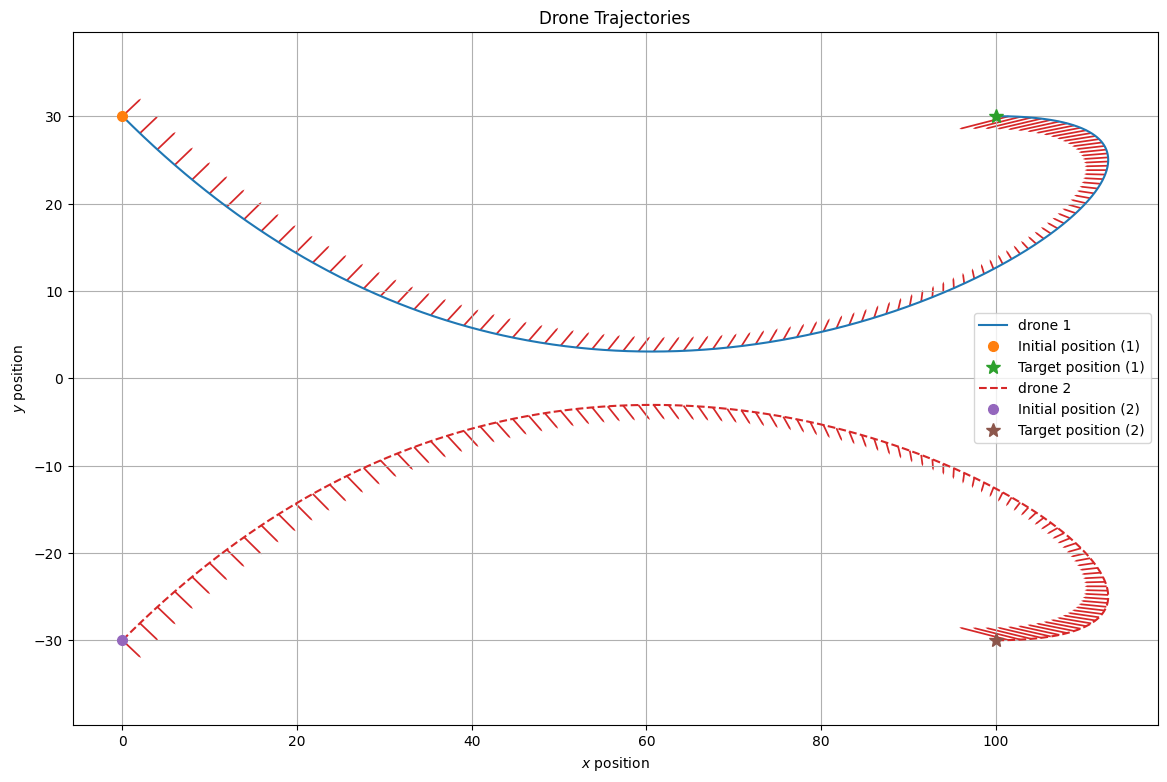

In [14]:
x1 = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u1 = cp.Variable((2,N))    # u_{0},...,u_{N-1}
x2 = cp.Variable((4,N+1))
u2 = cp.Variable((2,N))


u_lb = np.array([-1, -1])*0.5
u_ub = np.array([ 1,  1])*0.5

v_lb = np.array([-1, -1])*20
v_ub = np.array([ 1,  1])*20
D = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

# x1_0 = np.array([10, -20, 15, -5])
# x1_des = np.array([100, 50, 0, 0])

# x2_0 = x1_0 + np.array([0, 0, 5, 5])
# x2_des = x1_des + np.array([5, 5, 0, 0])

x1_0 = np.array([0, 30, 4, -4])
x2_0 = np.array([0, -30, 4, 4])

# x1_1 = np.array([50, 30, 2, 2])
# x2_1 = np.array([50, -30, 2, -2])

x1_des = np.array([100, 30, -3, 0])
x2_des = np.array([100, -30, -3, 0])

################### large divert
# x1_0 = np.array([10, -20, 15, -5])
# x2_0 = x1_0 + np.array([0, 0, 5, 5])

# x1_wpt1 = np.array([50, 20, 5, 5])

# x1_des = np.array([100, 50, 0, 0])
# x2_des = x1_des + np.array([5, 5, 0, 0])
####################

obj = cp.sum_squares(u1) + cp.sum_squares(u2)
obj = cp.Minimize(obj)

x1_cp_hist = []
u1_cp_hist = []   
x2_cp_hist = []
u2_cp_hist = []   
obj_hist = []

constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,
        #    x1[:2, int(N/2)] == C@x1_wpt1  
        #    x1[:, int(N//2)] == x1_1,
        #    x2[:, int(N//2)] == x2_1,
           ]
for t in range(N):
    constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
    constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]

prob = cp.Problem(obj, constr)
result = prob.solve(verbose=False)

obj_hist.append(prob.value)
x1_cp = np.array(x1.value)
u1_cp = np.array(u1.value)
x2_cp = np.array(x2.value)
u2_cp = np.array(u2.value)

x1_cp_hist.append(x1_cp)
u1_cp_hist.append(u1_cp)
x2_cp_hist.append(x2_cp)
u2_cp_hist.append(u2_cp)

x_cps = [x1_cp, x2_cp]
u_cps = [u1_cp, u2_cp]
x_0s = [x1_0, x2_0]
x_dess = [x1_des, x2_des]

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)
# plot_drone_states_controls(x_cps, u_cps, ts)

c:\Users\142857\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 29 05:38:45 PM: Your problem has 12008 variables, 9016 constraints, and 0 parameters.
(CVXPY) May 29 05:38:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 29 05:38:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 29 05:38:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 29 05:38:47 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 29 05:38:49 PM: Compiling problem (target solver=SCS).

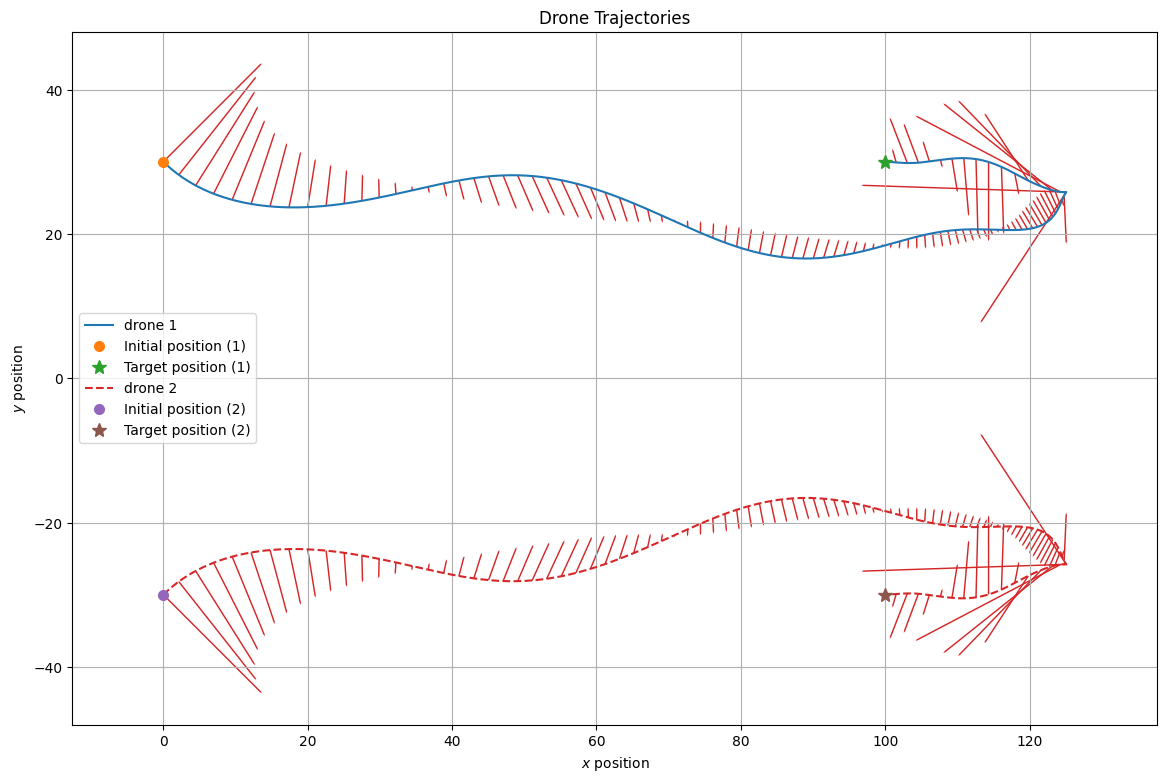

In [15]:
max_iters = 5

##########################
# p_obs = np.array([120,20])
d_sft = 10
# u_lb = 0.1
##########################

for iter in range(max_iters):
    x1_ref = x1_cp
    x2_ref = x2_cp
    
    u1_ref = u1_cp
    u2_ref = u2_cp

    # Trust region
    # alpha = 0.5  # damping factor
    # x1_ref = alpha * x1_cp + (1 - alpha) * x1_ref
    # x2_ref = alpha * x2_cp + (1 - alpha) * x2_ref

    obj = cp.sum_squares(u1) + cp.sum_squares(u2) 
    # obj = cp.Minimize(obj)
    
    constr = [ x1[:,-1] == x1_des,
           x1[:,0]  == x1_0,
           x2[:,-1] == x2_des,
           x2[:,0]  == x2_0,  
           ]
    for t in range(N):
        constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
        constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
        
        constr += [2 * (x1_ref[:2, t] - x2_ref[:2, t]).T @ (x1[:2, t] - x2[:2, t]) >= d_sft**2 + cp.sum_squares(x1_ref[:2, t] - x2_ref[:2, t])]
        
        # constr += [x1_ref[2:,t].T @ u1[:,t] == 0]
        # constr += [x2_ref[2:,t].T @ u2[:,t] == 0]
        
        # soft panelty
        # |vᵀu| = 0
        obj += 100000 * cp.sum_squares(x1_ref[2:,t].T @ u1[:,t])
        obj += 100000 * cp.sum_squares(x2_ref[2:,t].T @ u2[:,t])

        # 1 / |vᵀu|
        # obj += 1000 * cp.log(1 + cp.abs(x1_ref[2:, t].T @ u1[:, t]) + 1e-3) 
        # obj += 1000 * cp.log(1 + cp.abs(x2_ref[2:, t].T @ u2[:, t]) + 1e-3)

    obj = cp.Minimize(obj)
    prob = cp.Problem(obj, constr)
    result = prob.solve(solver=cp.SCS, verbose=True)
    # cp.Problem(obj, constr).solve(verbose=True)
    
    # 결과가 유효한 경우만 기록
    if prob.status in ['optimal', 'optimal_inaccurate']:
        x1_cp = np.array(x1.value)
        u1_cp = np.array(u1.value)
        x2_cp = np.array(x2.value)
        u2_cp = np.array(u2.value)

        x1_cp_hist.append(x1_cp)
        u1_cp_hist.append(u1_cp)
        x2_cp_hist.append(x2_cp)
        u2_cp_hist.append(u2_cp)
        obj_hist.append(prob.value) 

        print(f"Iteration {iter}: objective = {prob.value:.4f}")

        cond_1 = np.linalg.norm(x1_cp_hist[-1][:2] - x1_cp_hist[-2][:2], 'fro') < 1.0
        cond_2 = np.linalg.norm(x2_cp_hist[-1][:2] - x2_cp_hist[-2][:2], 'fro') < 1.0

        if cond_1 and cond_2:
            n_iters = len(x1_cp_hist)
            print(f"Terminated after {iter+1} iterations")
            break
    else:
        print(f"Iteration {iter}: infeasible solution, skipping")
        break

    print(f'############### iter = {iter} ###############')
    
    if iter == max_iters-1 :
        n_iters = len(x1_cp_hist)
    
x_cps = [x1_cp, x2_cp]
u_cps = [u1_cp, u2_cp]
x_0s = [x1_0, x2_0]
x_dess = [x1_des, x2_des]

for i in range(len(obj_hist)):
    print(f"Iteration {i}: objective = {obj_hist[i]:.4f}")

plot_drone_trajectories(x_cps, u_cps, x_0s, x_dess, N)
# plot_drone_states_controls(x_cps, u_cps, ts)

In [16]:
def plot_scp_solutions(x_cp_list, u_cp_list, x0_list, x_des_list, ts, n_iters):
    plt.figure(figsize=(14,6), dpi=100)
    plt.subplot(2,2,1)
    for id in range(n_iters):
        for x in x_cp_list:
            plt.plot(ts,x[id][0,:], color=plt.cm.tab20(0), \
                    linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
    plt.xlabel('time')
    plt.ylabel(r'$p_x$')
    plt.grid()
    plt.subplot(2,2,2)
    for id in range(n_iters):
        for y in x_cp_list:
            plt.plot(ts,y[id][1,:], color=plt.cm.tab20(0), \
                    linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
    plt.xlabel('time')
    plt.ylabel(r'$p_y$')
    plt.grid()
    plt.subplot(2,2,3)
    for id in range(n_iters):
        for vx in x_cp_list:
            plt.plot(ts,ux[id][2,:], color=plt.cm.tab20(0), \
                    linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
    plt.xlabel('time')
    plt.ylabel(r'$v_x$')
    plt.grid()
    plt.subplot(2,2,4)
    for id in range(n_iters):
        for vy in x_cp_list:
            plt.plot(ts,vy[id][3,:], color=plt.cm.tab20(0), \
                    linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
    plt.xlabel('time')
    plt.ylabel(r'$v_y$')
    plt.grid()
    plt.show()

    plt.figure(figsize=(14,6), dpi=100)
    plt.subplot(2,2,1)
    for id in range(n_iters):
        for ux in u_cp_list:
            plt.plot(ts[:-1],ux[id][0,:], color=plt.cm.tab20(0), \
                    linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
    plt.xlabel('time')
    plt.ylabel(r'$u_x$')
    plt.grid()
    plt.subplot(2,2,2)
    for id in range(n_iters):
        for uy in u_cp_list:
            plt.plot(ts[:-1],uy[id][1,:], color=plt.cm.tab20(0), \
                    linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
    plt.xlabel('time')
    plt.ylabel(r'$u_y$')
    plt.grid()
    plt.show()
    plt.figure(figsize=(14,4), dpi=100)
    for id in range(n_iters):
        for u in u_cp_list:
            plt.plot(ts[:-1],np.linalg.norm(u[id],axis=0), \
                    color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
                    alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
    plt.xlabel('time')
    plt.ylabel(r'$||u||$')
    # plt.axhline(u_ub, color=plt.cm.tab20(2), alpha=0.5, label=r'$u_{ub}$')
    # plt.axhline(u_lb, color=plt.cm.tab20(4), alpha=0.5, label=r'$u_{lb}$')
    plt.legend()
    plt.grid()
    plt.show()

    axes = plt.figure(num=1, figsize=(14,9), dpi=100)
    # plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
    #                 alpha = 0.1, label='Feasible region')
    x1_0 = x0_list[0]
    x2_0 = x0_list[1]
    plt.plot(x1_0[0], x1_0[1], 'o', markersize=7, label='Initial position (1)')
    plt.plot(x2_0[0], x2_0[1], 'o', markersize=7, label='Initial position (2)')
    plt.plot(x1_des[0], x1_des[1], '*', markersize=10, label='Target position (1)')
    plt.plot(x2_des[0], x2_des[1], '*', markersize=10, label='Target position (2)')
    # plt.gca().add_artist(plt.Circle((p_obs[0],p_obs[1]),d_sft, label='Obstable', \
    #                                 color=plt.cm.tab20(8), alpha=0.5))
    for id in range(n_iters):
        for x in x_cp_list:
            plt.plot(x[id][0,:], x[id][1,:], \
                    color=plt.cm.tab20(4), linewidth=0.5+(id+1)/n_iters*2, \
                    alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory (1), iter={id}')
    plt.legend()
    plt.title('Trajectories')

    # for t in range(0,N,10):
    #     for x in x_cp_list:
    #         plt.arrow(x1_cp_hist[id][0,t], x1_cp_hist[id][1,t], \
    #                     10*u1_cp_hist[id][0,t], 10*u1_cp_hist[id][1,t], \
    #                     head_width=1.2, width=0.2, color='r', ec='none')
  
    plt.axis('equal')
    plt.xlabel(r'$x$ position')
    plt.ylabel(r'$y$ position')
    plt.grid()
    plt.show()

UnboundLocalError: cannot access local variable 'ux' where it is not associated with a value

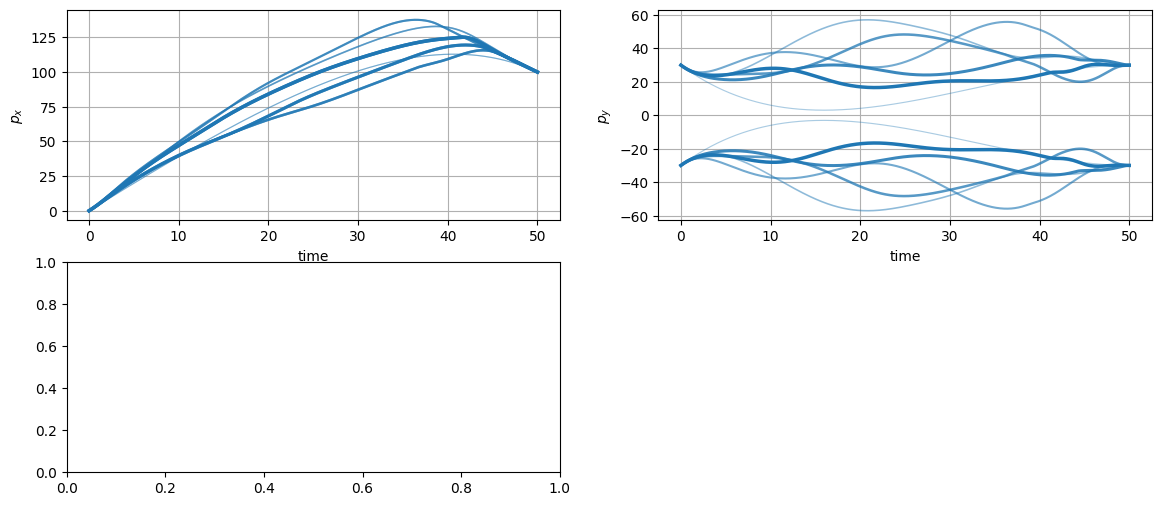

In [17]:
plot_scp_solutions(
    x_cp_list=[x1_cp_hist, x2_cp_hist],  # shape: [n_iters][4, N+1]
    u_cp_list=[u1_cp_hist, u2_cp_hist],  # shape: [n_iters][2, N]
    x0_list=[x1_0, x2_0],
    x_des_list=[x1_des, x2_des],
    ts=ts,
    n_iters=n_iters)


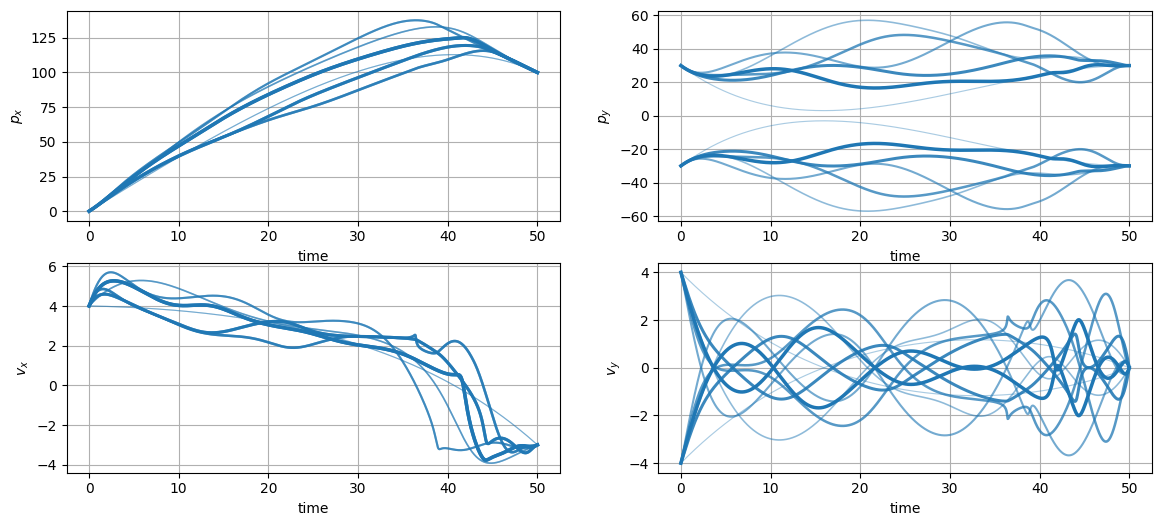

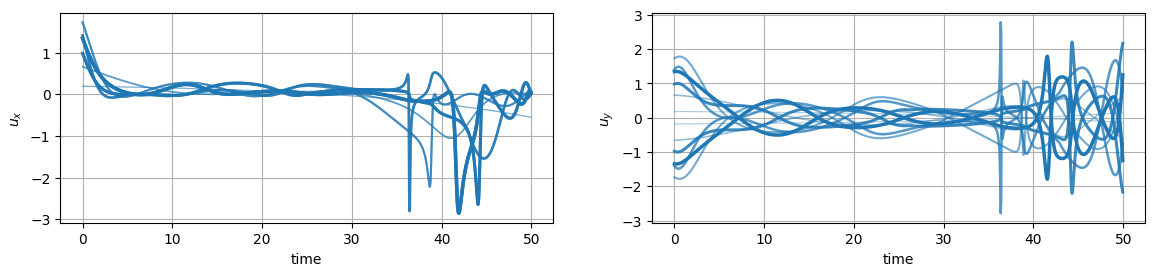

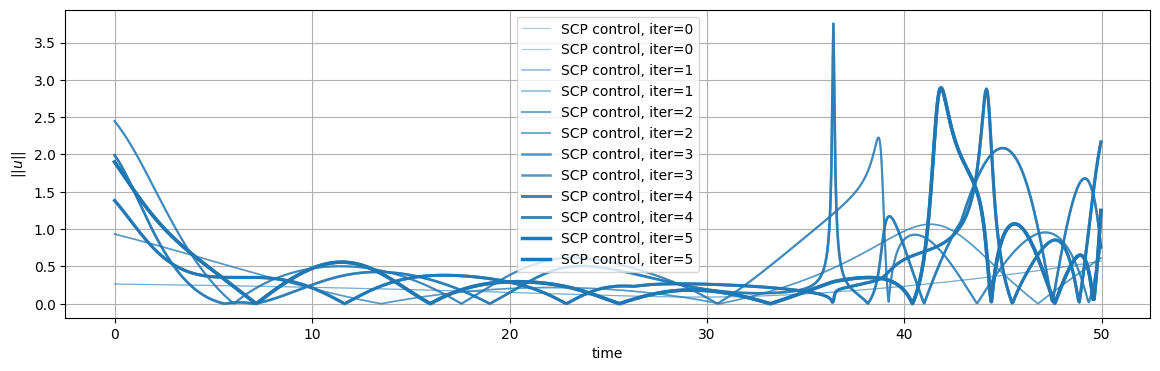

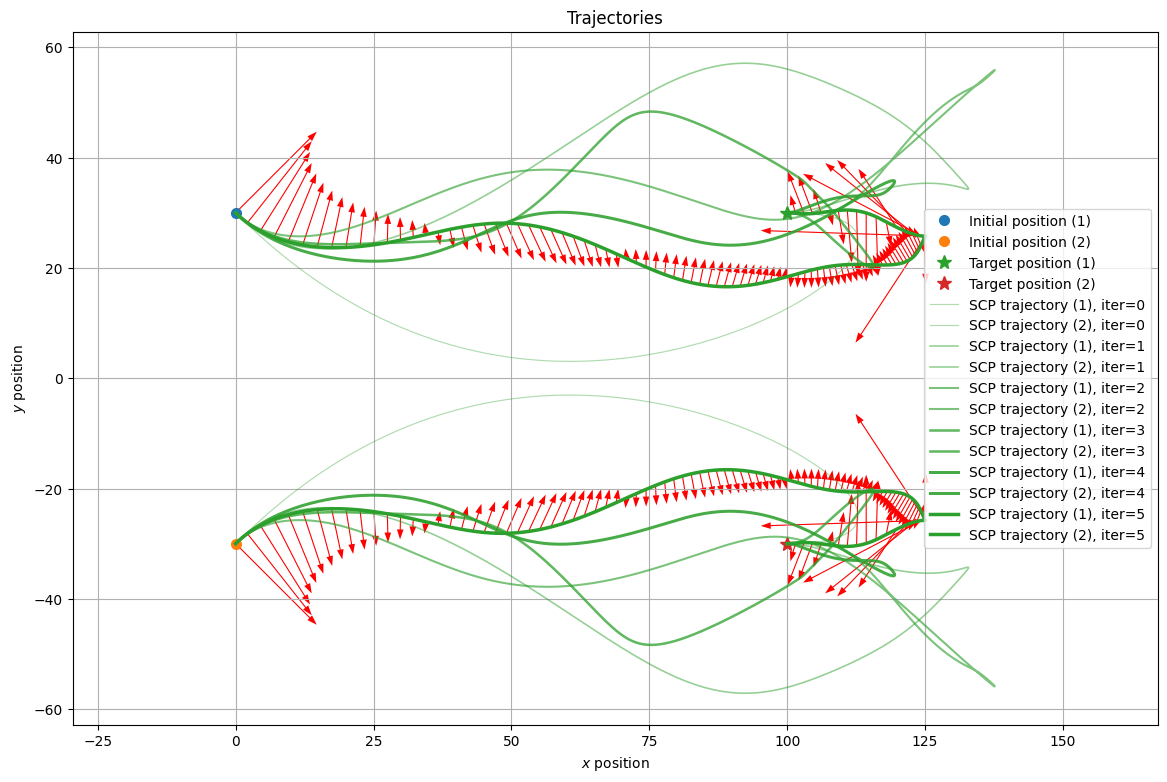

In [18]:
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_y$')
plt.grid()
plt.subplot(2,2,3)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][2,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][2,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_x$')
plt.grid()
plt.subplot(2,2,4)
for id in range(n_iters):
  plt.plot(ts,x1_cp_hist[id][3,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts,x2_cp_hist[id][3,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_y$')
plt.grid()
plt.show()

plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts[:-1],u1_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts[:-1],u2_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts[:-1],u1_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
  plt.plot(ts[:-1],u2_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_y$')
plt.grid()
plt.show()
plt.figure(figsize=(14,4), dpi=100)
for id in range(n_iters):
  plt.plot(ts[:-1],np.linalg.norm(u1_cp_hist[id],axis=0), \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
  plt.plot(ts[:-1],np.linalg.norm(u2_cp_hist[id],axis=0), \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
plt.xlabel('time')
plt.ylabel(r'$||u||$')
# plt.axhline(u_ub, color=plt.cm.tab20(2), alpha=0.5, label=r'$u_{ub}$')
# plt.axhline(u_lb, color=plt.cm.tab20(4), alpha=0.5, label=r'$u_{lb}$')
plt.legend()
plt.grid()
plt.show()

axes = plt.figure(num=1, figsize=(14,9), dpi=100)
# plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
#                 alpha = 0.1, label='Feasible region')
plt.plot(x1_0[0], x1_0[1], 'o', markersize=7, label='Initial position (1)')
plt.plot(x2_0[0], x2_0[1], 'o', markersize=7, label='Initial position (2)')
plt.plot(x1_des[0], x1_des[1], '*', markersize=10, label='Target position (1)')
plt.plot(x2_des[0], x2_des[1], '*', markersize=10, label='Target position (2)')
# plt.gca().add_artist(plt.Circle((p_obs[0],p_obs[1]),d_sft, label='Obstable', \
#                                 color=plt.cm.tab20(8), alpha=0.5))
for id in range(n_iters):
  plt.plot(x1_cp_hist[id][0,:], x1_cp_hist[id][1,:], \
           color=plt.cm.tab20(4), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory (1), iter={id}')
  plt.plot(x2_cp_hist[id][0,:], x2_cp_hist[id][1,:], \
           color=plt.cm.tab20(4), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory (2), iter={id}')

plt.legend()
plt.title('Trajectories')

for t in range(0,N,10):
  plt.arrow(x1_cp_hist[id][0,t], x1_cp_hist[id][1,t], \
            10*u1_cp_hist[id][0,t], 10*u1_cp_hist[id][1,t], \
            head_width=1.2, width=0.2, color='r', ec='none')
  plt.arrow(x2_cp_hist[id][0,t], x2_cp_hist[id][1,t], \
            10*u2_cp_hist[id][0,t], 10*u2_cp_hist[id][1,t], \
            head_width=1.2, width=0.2, color='r', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

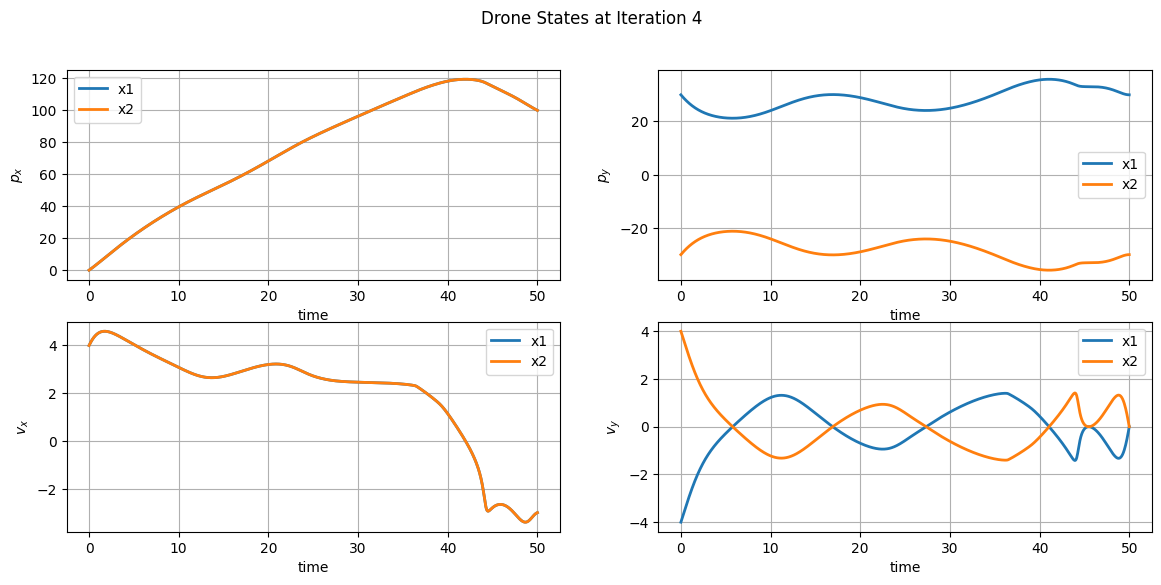

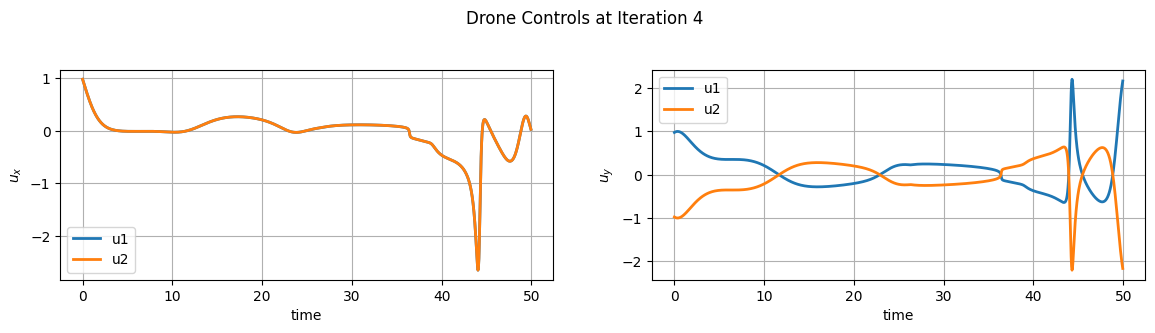

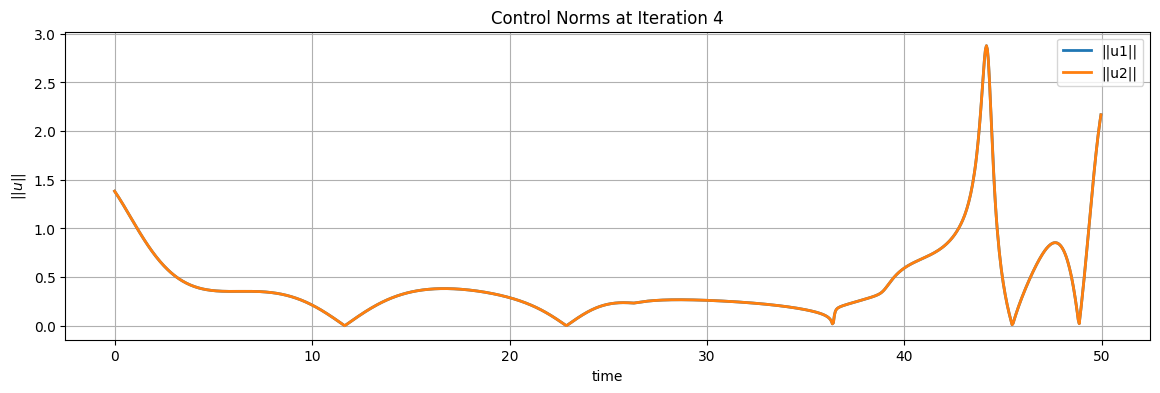

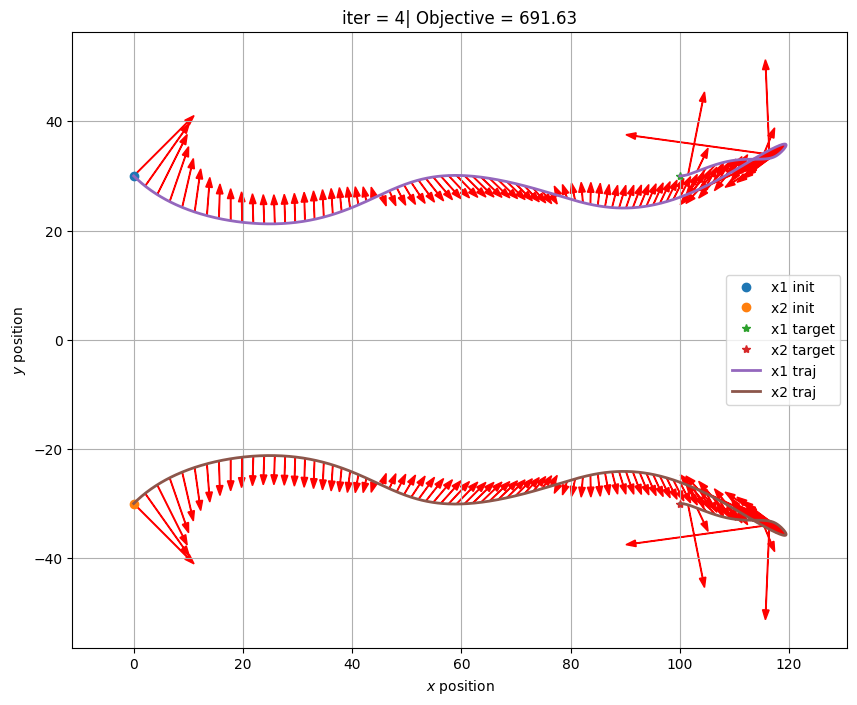

In [24]:
plot_scp_iteration(4,x1_cp_hist,x2_cp_hist,u1_cp_hist,u2_cp_hist,x1_0,x2_0,x1_des,x2_des,ts,N, obj_hist)

# MPC

error로 disturbance 넣어서 MPC로 만들어볼까?

상태전파할 때 비선형 동역학으로 반영하면 뭔가 의미가 있으려니?

In [7]:
def propagate_state(x, u, A, B, noise_std=0.1):
    """외란 포함 상태 전파"""
    w = np.random.randn(*x.shape) * noise_std
    return A @ x + B @ u + w

def initial_scp(x0, x_des, A, B, N):
    n, m = A.shape[0], B.shape[1]
    x1 = cp.Variable((n, N+1))
    x2 = cp.Variable((n, N+1))
    u1 = cp.Variable((m, N))
    u2 = cp.Variable((m, N))
    
    obj = cp.sum_squares(u1) + cp.sum_squares(u2)

    constr = [x1[:,0] == x0[0], 
              x2[:,0] == x0[1], 
              x1[:,-1] == x_des[0], 
              x2[:,-1] == x_des[1]]
    for t in range(N):
        constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
        constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]

    prob = cp.Problem(cp.Minimize(obj), constr)
    prob.solve(solver=cp.SCS, verbose=False)
    
    return x1.value, x2.value, u1.value, u2.value

def solve_scp(x0, x_des, A, B, N, x1_ref, x2_ref, u1_ref, u2_ref, d_sft, u_lb=None, u_ub=None, max_iters=5):
    """SCP 최적화 문제 풀기"""
    n, m = A.shape[0], B.shape[1]
    x1 = cp.Variable((n, N+1))
    x2 = cp.Variable((n, N+1))
    u1 = cp.Variable((m, N))
    u2 = cp.Variable((m, N))

    for iter in range(max_iters):
        obj = cp.sum_squares(u1) + cp.sum_squares(u2) 
        constr = [x1[:,0] == x0[0], 
                  x2[:,0] == x0[1], 
                  x1[:,-1] == x_des[0], 
                  x2[:,-1] == x_des[1]]
        
        for t in range(N):
            constr += [ x1[:,t+1] == A@x1[:,t] + B@u1[:,t] ] # dynamics equation
            constr += [ x2[:,t+1] == A@x2[:,t] + B@u2[:,t] ]
            constr += [2 * (x1_ref[:2, t] - x2_ref[:2, t]).T @ (x1[:2, t] - x2[:2, t]) >= d_sft**2 + cp.sum_squares(x1_ref[:2, t] - x2_ref[:2, t])]
            
            # soft panelty
            # obj += 100000 * cp.sum_squares(x1_ref[2:,t].T @ u1[:,t])
            # obj += 100000 * cp.sum_squares(x2_ref[2:,t].T @ u2[:,t])
            
            if u_lb is not None and u_ub is not None:
                constr += [ u_lb <= u1[:,t], u1[:,t] <= u_ub ]
                constr += [ u_lb <= u2[:,t], u2[:,t] <= u_ub ]
                pass

        prob = cp.Problem(cp.Minimize(obj), constr)
        result = prob.solve(solver=cp.SCS, verbose=False)
        # cp.Problem(obj, constr).solve(verbose=True)
        
        if prob.status in ['optimal', 'optimal_inaccurate']:
            print(f"Iteration {iter}: objective = {prob.value:.4f}")

            cond_1 = np.linalg.norm(x1.value[:2] - x1_ref[:2], 'fro') < 1.0
            cond_2 = np.linalg.norm(x2.value[:2] - x2_ref[:2], 'fro') < 1.0

            if cond_1 and cond_2:
                # print(f"Terminated after {iter+1} iterations")
                break
        else:
            print(f"Iteration {iter}: infeasible solution, skipping")
            break
        
        x1_ref = x1.value
        x2_ref = x2.value
        u1_ref = u1.value
        u2_ref = u2.value

    return x1.value, x2.value, u1.value, u2.value

In [9]:
# 초기 세팅
x1_0 = np.array([0, 30, 4, -50])
x2_0 = np.array([0, -30, 4, 50])

# x1_1 = np.array([50, 30, 2, 2])
# x2_1 = np.array([50, -30, 2, -2])

x1_des = np.array([100, 30, -0, 0])
x2_des = np.array([100, -30, -0, 0])

x1_curr = x1_0.copy()
x2_curr = x2_0.copy()

x1_history = [x1_curr]
x2_history = [x2_curr]
u1_history = []
u2_history = []

# max_iters = 5
d_sft = 20

T = 50          # 총 시뮬레이션 시간
N = 50          # SCP horizon : number of time steps
M = 2             # 실행 스텝
noise_std = 0.5  # 외란 세기

u_lb = np.array([-1, -1])*1000
u_ub = np.array([ 1,  1])*1000

for t_iter in range(0, N, M):
    print(f"--- MPC Iteration {t_iter//M} ---")
    N_remain = min(N, N-t_iter)
                   
    # SCP 풀기
    x0s = [x1_curr, x2_curr]
    if t_iter == 0:
        x1_prev, x2_prev, u1_prev, u2_prev = initial_scp(x0s, [x1_des, x2_des], A, B, N_remain)
        x1_ref = x1_prev
        x2_ref = x2_prev
        u1_ref = u1_prev
        u2_ref = u2_prev
    else:
        x1_ref = x1_prev[:, M : M + N_remain + 1]
        x2_ref = x2_prev[:, M : M + N_remain + 1]
        u1_ref = u1_prev[:, M : M + N_remain]
        u2_ref = u2_prev[:, M : M + N_remain]
    # x1_ref = np.tile(x1_curr.reshape(-1,1), (1,N+1))  # 초기 reference
    # x2_ref = np.tile(x2_curr.reshape(-1,1), (1,N+1))
    # u1_ref = np.zeros((B.shape[1], N))
    # u2_ref = np.zeros((B.shape[1], N))

      
    x1_traj, x2_traj, u1_traj, u2_traj = solve_scp(x0s, [x1_des, x2_des], A, B, N_remain, x1_ref, x2_ref, u1_ref, u2_ref, d_sft, u_lb=u_lb, u_ub=u_ub)

    # M-step 실행
    for k in range(M):
        u1_apply = u1_traj[:, k]
        u2_apply = u2_traj[:, k]
        
        x1_curr = propagate_state(x1_curr, u1_apply, A, B, noise_std)
        x2_curr = propagate_state(x2_curr, u2_apply, A, B, noise_std)
        
        x1_history.append(x1_curr)
        x2_history.append(x2_curr)
        u1_history.append(u1_apply)
        u2_history.append(u2_apply)
        
    x1_prev = x1_traj
    x2_prev = x2_traj
    u1_prev = u1_traj
    u2_prev = u2_traj

print("SCP-MPC done")

--- MPC Iteration 0 ---
Iteration 0: objective = 432093.4974
--- MPC Iteration 1 ---
Iteration 0: objective = 371792.2082
Iteration 1: objective = 371792.1106
--- MPC Iteration 2 ---
Iteration 0: objective = 325199.8452
Iteration 1: objective = 325199.8946
--- MPC Iteration 3 ---
Iteration 0: objective = 289818.1428
Iteration 1: objective = 289816.8515
--- MPC Iteration 4 ---
Iteration 0: objective = 254447.1093
Iteration 1: objective = 254454.9232
--- MPC Iteration 5 ---
Iteration 0: objective = 226322.9939
Iteration 1: objective = 226322.4875
--- MPC Iteration 6 ---
Iteration 0: objective = 200333.9378
Iteration 1: objective = 200334.7447
--- MPC Iteration 7 ---
Iteration 0: objective = 178977.7570
Iteration 1: objective = 178978.0210
--- MPC Iteration 8 ---
Iteration 0: objective = 176070.8347
Iteration 1: objective = 176070.8761
--- MPC Iteration 9 ---
Iteration 0: objective = 166299.1491
Iteration 1: objective = 166298.6950
--- MPC Iteration 10 ---
Iteration 0: objective = 166393.

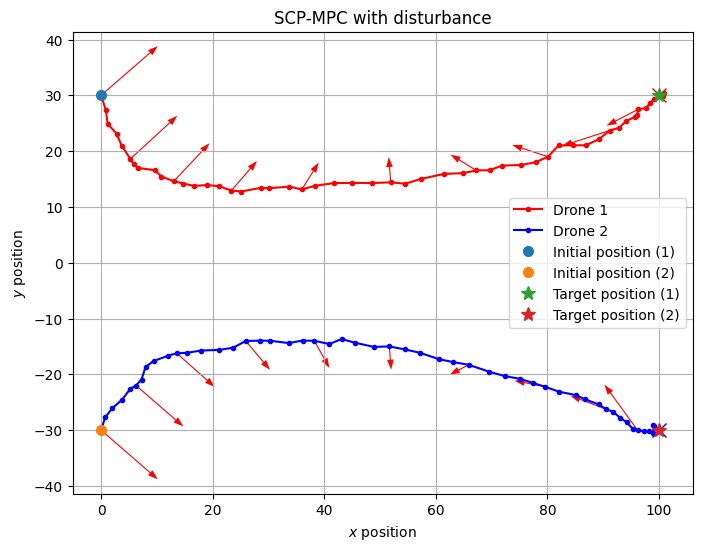

In [10]:
x1_history = np.array(x1_history)
x2_history = np.array(x2_history)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(x1_history[:,0], x1_history[:,1], 'r-o', markersize=3, label='Drone 1')
plt.plot(x2_history[:,0], x2_history[:,1], 'b-o', markersize=3, label='Drone 2')
plt.plot(x1_des[0], x1_des[1], 'rx', markersize=10)
plt.plot(x2_des[0], x2_des[1], 'bx', markersize=10)
plt.grid(); plt.legend(); plt.title("SCP-MPC with disturbance")

axes = plt.figure(num=1, figsize=(14,9), dpi=100)
# plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
#                 alpha = 0.1, label='Feasible region')
plt.plot(x1_0[0], x1_0[1], 'o', markersize=7, label='Initial position (1)')
plt.plot(x2_0[0], x2_0[1], 'o', markersize=7, label='Initial position (2)')
plt.plot(x1_des[0], x1_des[1], '*', markersize=10, label='Target position (1)')
plt.plot(x2_des[0], x2_des[1], '*', markersize=10, label='Target position (2)')

u_plot_weight = 0.1
for t in range(0,N, 5):
  plt.arrow(x1_history[t][0], x1_history[t][1], \
            u_plot_weight*u1_history[t][0], u_plot_weight*u1_history[t][1], \
            head_width=1.2, width=0.2, color='r', ec='none')
  plt.arrow(x2_history[t][0], x2_history[t][1], \
            u_plot_weight*u2_history[t][0], u_plot_weight*u2_history[t][1], \
            head_width=1.2, width=0.2, color='r', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.legend()
plt.show()

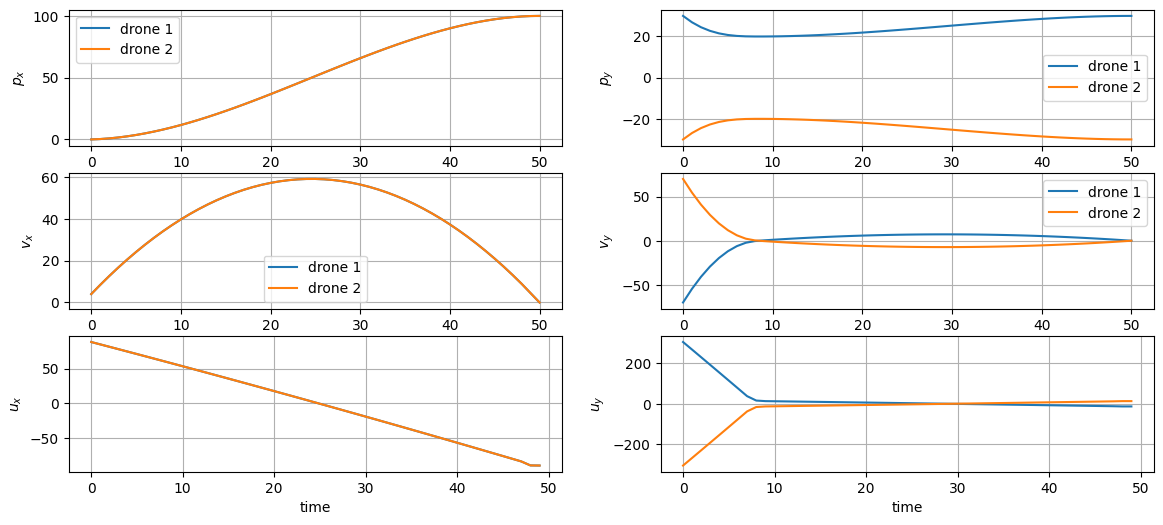

In [130]:
n_iters = N
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(3,2,1)
plt.plot(x1_history[:,0], label='drone 1')
plt.plot(x2_history[:,0], label='drone 2')
plt.xlabel('time')
plt.ylabel(r'$p_x$')
plt.legend()
plt.grid()

plt.subplot(3,2,2)
plt.plot(x1_history[:,1], label='drone 1')
plt.plot(x2_history[:,1], label='drone 2')
plt.xlabel('time')
plt.ylabel(r'$p_y$')
plt.legend()
plt.grid()

plt.subplot(3,2,3)
plt.plot(x1_history[:,2], label='drone 1')
plt.plot(x2_history[:,2], label='drone 2')
plt.xlabel('time')
plt.ylabel(r'$v_x$')
plt.legend()
plt.grid()

plt.subplot(3,2,4)
plt.plot(x1_history[:,3], label='drone 1')
plt.plot(x2_history[:,3], label='drone 2')
plt.xlabel('time')
plt.ylabel(r'$v_y$')
plt.legend()
plt.grid()

u1_x = [u[0] for u in u1_history]
u2_x = [u[0] for u in u2_history]
u1_y = [u[1] for u in u1_history]
u2_y = [u[1] for u in u2_history]

plt.subplot(3,2,5)
plt.plot(u1_x, label='drone 1')
plt.plot(u2_x, label='drone 2')
plt.xlabel('time')
plt.ylabel(r'$u_x$')
plt.grid()

plt.subplot(3,2,6)
plt.plot(u1_y, label='drone 1')
plt.plot(u2_y, label='drone 2')
plt.xlabel('time')
plt.ylabel(r'$u_y$')
plt.grid()
plt.show()

# Minimum Time

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

In [3]:
x_0 = np.array([10, -20, 15, -5])
x_des = np.array([100, 50, 0, 0])

u_max = 1.0

In [7]:
import cvxpy as cp

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A@x[:,t] + B@u[:,t] ]
    constr += [ cp.norm(u[:,t]) <= u_max ]
    
prob = cp.Problem(obj, constr)
prob.solve(solver=cp.SCS, verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 29 05:26:23 PM: Your problem has 6004 variables, 5008 constraints, and 0 parameters.
(CVXPY) May 29 05:26:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 29 05:26:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 29 05:26:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 29 05:26:23 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 29 05:26:23 PM: Compiling problem (target solver=SCS).


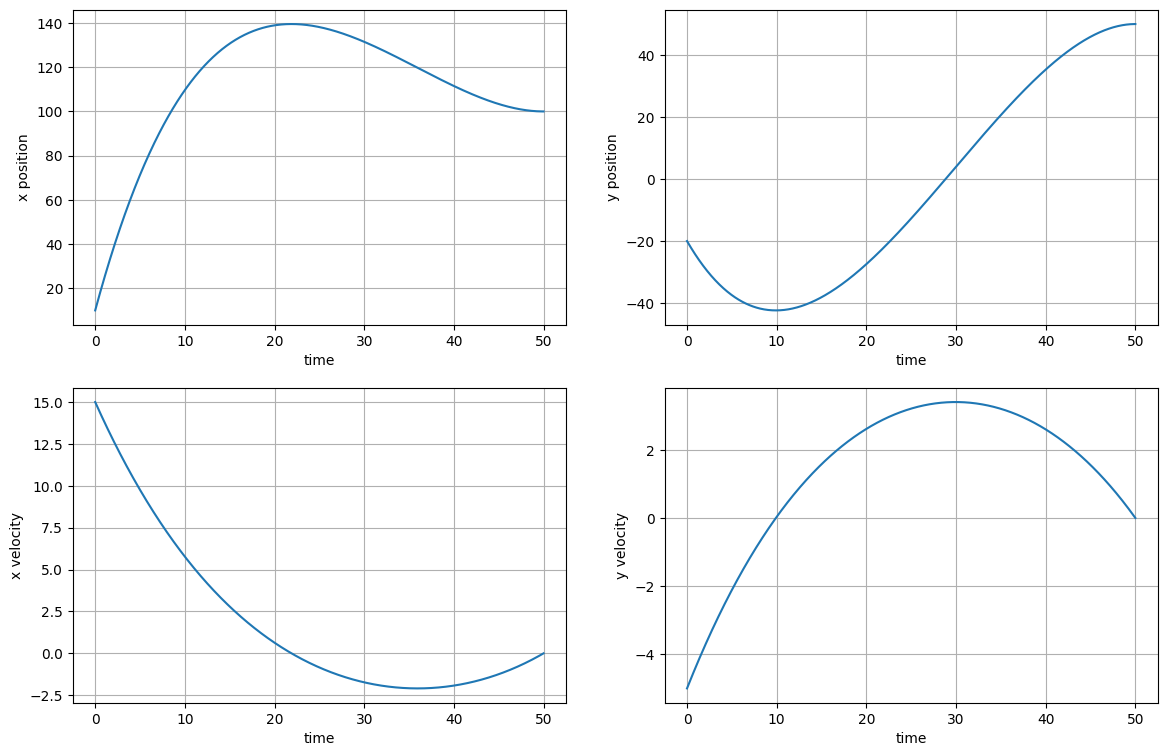

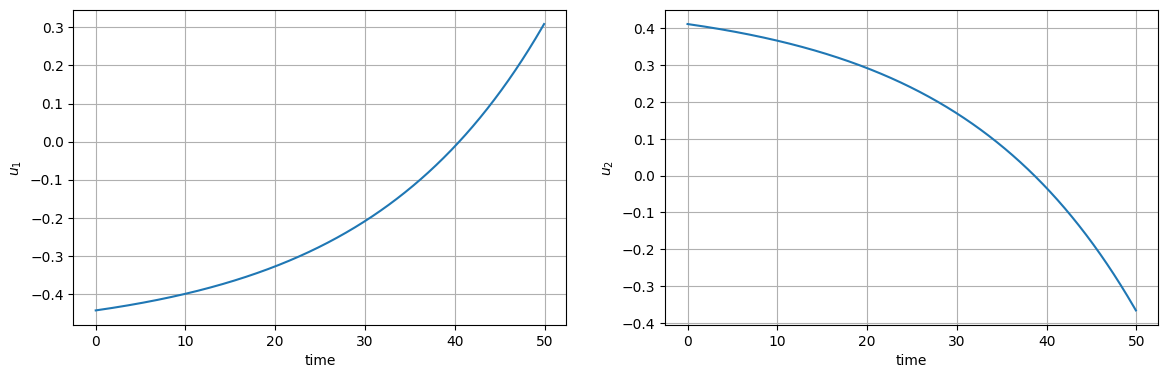

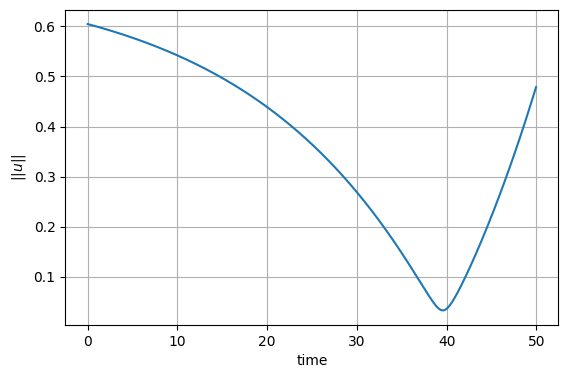

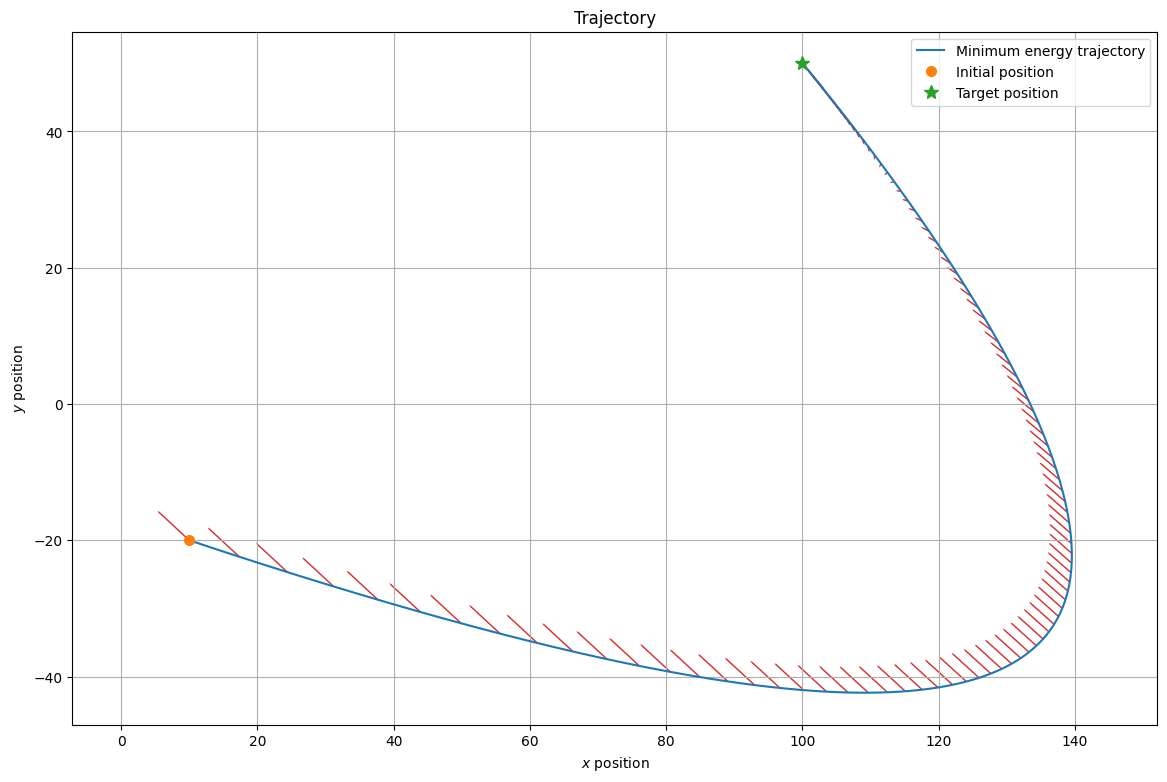

In [8]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_cp[0,:])
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_cp[1,:])
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_cp[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_cp[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_cp[0,:])
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_cp[1,:])
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],np.linalg.norm(u_cp,2,axis=0))
plt.xlabel('time')
plt.ylabel(r'$||u||$')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_cp[0,:],x_cp[1,:], label='Minimum energy trajectory')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(x_cp[0,i], x_cp[1,i], 10*u_cp[0,i], 10*u_cp[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

In [9]:
p_upper = N
p_lower = 0
epsilon = 1

while (p_upper - p_lower > epsilon):
  
  s = int(0.5*(p_upper+p_lower))
  print (f'UB:{p_upper}    LB:{p_lower}')
  
  tm = np.arange(s+1)*delt

  x = cp.Variable((4,s+1))  # x_{0},...,x_{s}
  u = cp.Variable((2,s))    # u_{0},...,u_{s-1}

  obj = cp.Minimize(cp.sum_squares(u))

  constr = [ x[:,-1] == x_des, 
             x[:,0]  == x_0    ]
  for t in range(s):
      constr += [ x[:,t+1] == A@x[:,t] + B@u[:,t] ]
      constr += [ cp.norm(u[:,t]) <= u_max ]
    
  prob = cp.Problem(obj, constr)
  prob.solve(solver=cp.ECOS)
  
  if prob.status == 'optimal':
    p_upper = s
  else:
    p_lower = s

s = p_upper
tm = np.arange(s+1)*delt

x = cp.Variable((4,s+1))  # x_{0},...,x_{s}
u = cp.Variable((2,s))    # u_{0},...,u_{s-1}

obj = cp.Minimize(cp.sum_squares(u))

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(s):
    constr += [ x[:,t+1] == A@x[:,t] + B@u[:,t] ]
    constr += [ cp.norm(u[:,t]) <= u_max ]

    
prob = cp.Problem(obj, constr)
prob.solve(solver=cp.SCS)
    
x_mt = np.array(x.value)
u_mt = np.array(u.value)

UB:1000    LB:0
UB:1000    LB:500
UB:750    LB:500
UB:625    LB:500
UB:562    LB:500
UB:531    LB:500
UB:531    LB:515
UB:523    LB:515


c:\Users\142857\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


UB:523    LB:519
UB:521    LB:519


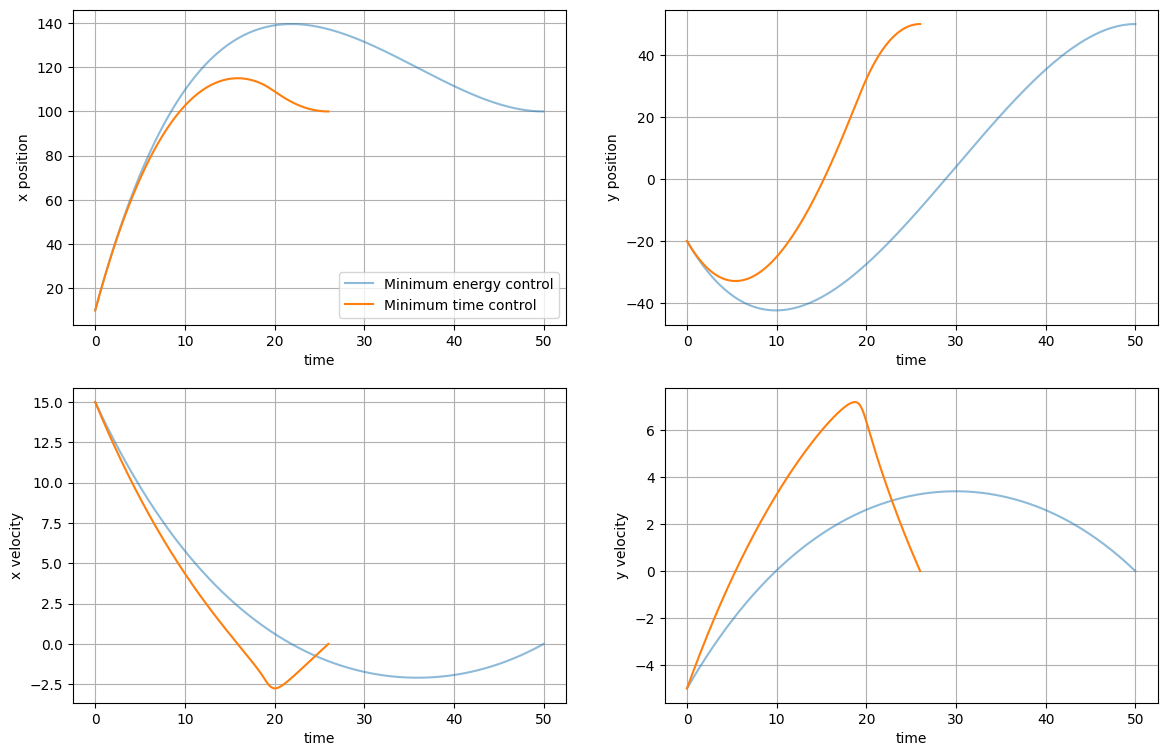

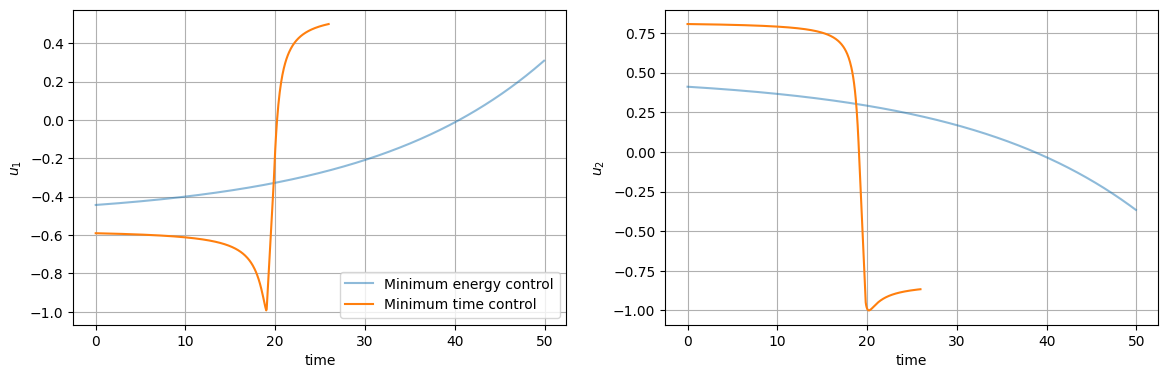

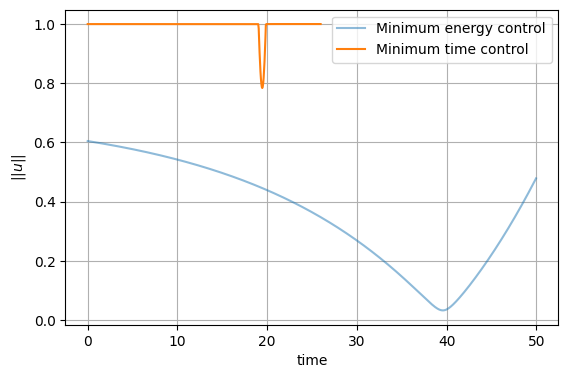

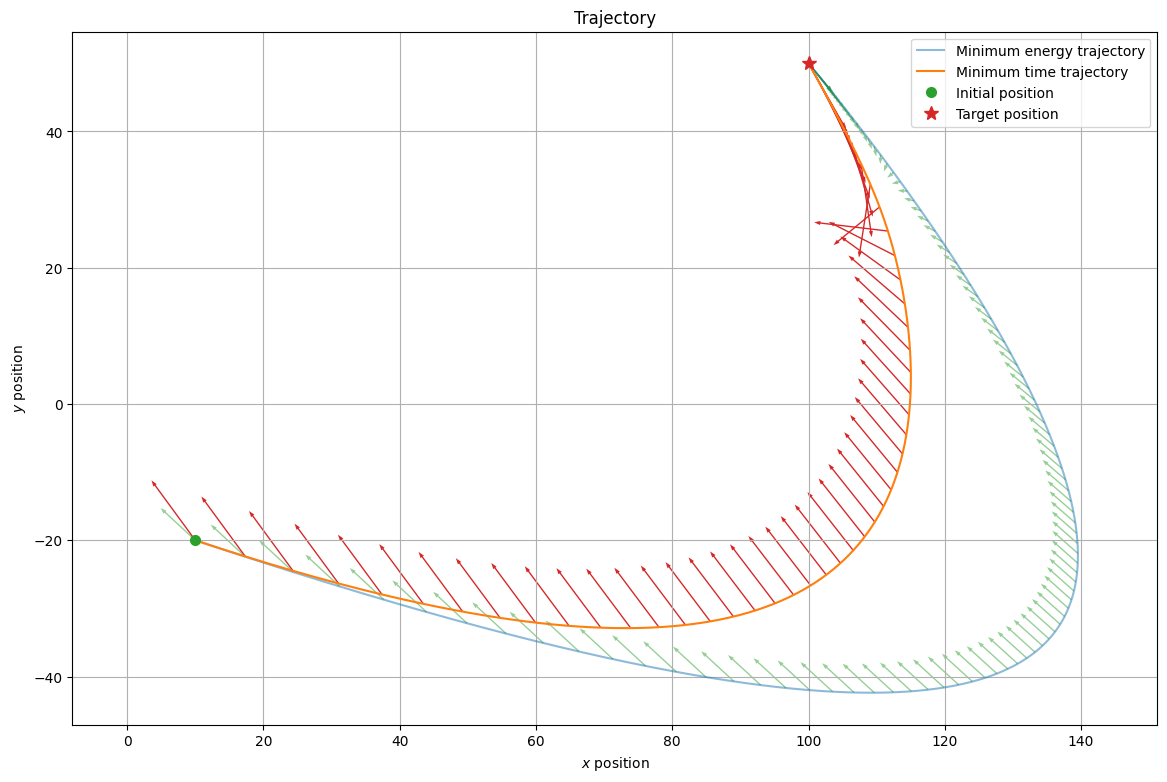

In [10]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_cp[0,:], alpha=0.5, label='Minimum energy control')
plt.plot(tm,x_mt[0,:], label='Minimum time control')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_cp[1,:], alpha=0.5)
plt.plot(tm,x_mt[1,:])
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_cp[2,:], alpha=0.5)
plt.plot(tm,x_mt[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_cp[3,:], alpha=0.5)
plt.plot(tm,x_mt[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_cp[0,:], alpha=0.5, label='Minimum energy control')
plt.plot(tm[:-1],u_mt[0,:], label='Minimum time control')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.legend()
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_cp[1,:], alpha=0.5)
plt.plot(tm[:-1],u_mt[1,:])
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],np.linalg.norm(u_cp,2,axis=0), alpha=0.5, label='Minimum energy control')
plt.plot(tm[:-1],np.linalg.norm(u_mt,2,axis=0), label='Minimum time control')
plt.xlabel('time')
plt.ylabel(r'$||u||$')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_cp[0,:],x_cp[1,:], alpha=0.5, label='Minimum energy trajectory')
plt.plot(x_mt[0,:],x_mt[1,:], label='Minimum time trajectory')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(x_cp[0,i], x_cp[1,i], 10*u_cp[0,i], 10*u_cp[1,i], head_width=0.6, width=0.2, alpha=0.5, fc='tab:green', ec='none')
for i in range(0,s-1,10):
  plt.arrow(x_mt[0,i], x_mt[1,i], 10*u_mt[0,i], 10*u_mt[1,i], head_width=0.6, width=0.2, alpha=1.0, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()